In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install transformers timm torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from sklearn.metrics import jaccard_score, f1_score
from tqdm import tqdm

In [5]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,  # Background and vessels
    ignore_mismatched_sizes=True
)
model.config.id2label = {0: "background", 1: "vessel"}
model.config.label2id = {"background": 0, "vessel": 1}

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class RetinaSegformerDataset(Dataset):
    def __init__(self, image_paths, mask_paths, fov_paths, feature_extractor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.fov_paths = fov_paths
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")

        mask_path = self.mask_paths[idx]
        if mask_path.endswith('.gif'):
            mask = np.array(Image.open(mask_path).convert('L'))
        else:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.uint8)
        mask = torch.tensor(mask, dtype=torch.long)

        fov_path = self.fov_paths[idx]
        if fov_path.endswith('.gif'):
            fov_mask = np.array(Image.open(fov_path).convert('L'))
        else:
            fov_mask = cv2.imread(fov_path, cv2.IMREAD_GRAYSCALE)
            if fov_mask is None:
                raise FileNotFoundError(f"FOV mask not found: {fov_path}")
        fov_mask = cv2.resize(fov_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        fov_mask = (fov_mask > 127).astype(np.float32)
        fov_mask = torch.tensor(fov_mask, dtype=torch.float32).unsqueeze(0)

        # Preprocess image with feature extractor
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)

        return pixel_values, mask, fov_mask

In [7]:
def unfreeze_backbone_layers(model, num_layers_to_unfreeze=2):
    backbone = model.segformer.encoder
    layers = list(backbone.named_children())[::-1]  # start from the last

    count = 0
    for name, layer in layers:
        for param in layer.parameters():
            param.requires_grad = True
        count += 1
        if count >= num_layers_to_unfreeze:
            break

    # Freeze the rest
    for name, layer in layers[count:]:
        for param in layer.parameters():
            param.requires_grad = False

# Unfreeze last 2 encoder blocks
unfreeze_backbone_layers(model, num_layers_to_unfreeze=2)

In [24]:
DATASET_PATH = '/content/drive/MyDrive/DRIVE/DRIVE/train'
image_paths = [os.path.join(DATASET_PATH, 'images', f) for f in os.listdir(os.path.join(DATASET_PATH, 'images'))]
mask_paths = [os.path.join(DATASET_PATH, '1st_manual', f) for f in os.listdir(os.path.join(DATASET_PATH, '1st_manual'))]
fov_paths = [os.path.join(DATASET_PATH, 'mask', f) for f in os.listdir(os.path.join(DATASET_PATH, 'mask'))]

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
dataset = RetinaSegformerDataset(image_paths, mask_paths, fov_paths, feature_extractor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
class_weights = torch.tensor([1.0, 10.0], device=device)  # Adjusted weights for class imbalance!
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")

<ipython-input-18-2f5ca89db890>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [19]:
for epoch in range(20):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")

Epoch 1 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 1: Train Loss=0.7554, Val Loss=0.5663, IoU=0.1402, Dice=0.2459
Best model saved!


Epoch 2 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 2: Train Loss=0.6650, Val Loss=0.5707, IoU=0.1358, Dice=0.2391


Epoch 3 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 3: Train Loss=0.6005, Val Loss=0.5726, IoU=0.1356, Dice=0.2388


Epoch 4 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 4: Train Loss=0.5732, Val Loss=0.5691, IoU=0.1356, Dice=0.2388


Epoch 5 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 5: Train Loss=0.5633, Val Loss=0.5629, IoU=0.1345, Dice=0.2372
Best model saved!


Epoch 6 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch 6: Train Loss=0.5638, Val Loss=0.5584, IoU=0.1348, Dice=0.2376
Best model saved!


Epoch 7 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 7: Train Loss=0.5586, Val Loss=0.5571, IoU=0.1358, Dice=0.2391
Best model saved!


Epoch 8 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 8: Train Loss=0.5537, Val Loss=0.5575, IoU=0.1421, Dice=0.2488


Epoch 9 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 9: Train Loss=0.5519, Val Loss=0.5608, IoU=0.1463, Dice=0.2552


Epoch 10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 10: Train Loss=0.5526, Val Loss=0.5557, IoU=0.1461, Dice=0.2549
Best model saved!


Epoch 11 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 11: Train Loss=0.5504, Val Loss=0.5520, IoU=0.1442, Dice=0.2521
Best model saved!


Epoch 12 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 12: Train Loss=0.5498, Val Loss=0.5499, IoU=0.1433, Dice=0.2506
Best model saved!


Epoch 13 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 13: Train Loss=0.5501, Val Loss=0.5492, IoU=0.1425, Dice=0.2494
Best model saved!


Epoch 14 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 14: Train Loss=0.5510, Val Loss=0.5486, IoU=0.1422, Dice=0.2491
Best model saved!


Epoch 15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 15: Train Loss=0.5482, Val Loss=0.5481, IoU=0.1424, Dice=0.2493
Best model saved!


Epoch 16 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 16: Train Loss=0.5492, Val Loss=0.5492, IoU=0.1444, Dice=0.2523


Epoch 17 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 17: Train Loss=0.5489, Val Loss=0.5514, IoU=0.1462, Dice=0.2551


Epoch 18 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 18: Train Loss=0.5455, Val Loss=0.5516, IoU=0.1463, Dice=0.2553


Epoch 19 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 19: Train Loss=0.5444, Val Loss=0.5504, IoU=0.1459, Dice=0.2546


Epoch 20 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-19-41d0cea9f575>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 20: Train Loss=0.5471, Val Loss=0.5485, IoU=0.1436, Dice=0.2511


Epoch 1 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 1: Train Loss=0.5429, Val Loss=0.5490, IoU=0.1443, Dice=0.2522


Epoch 2 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 2: Train Loss=0.5442, Val Loss=0.5484, IoU=0.1430, Dice=0.2502


Epoch 3 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 3: Train Loss=0.5478, Val Loss=0.5489, IoU=0.1434, Dice=0.2509


Epoch 4 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 4: Train Loss=0.5445, Val Loss=0.5511, IoU=0.1452, Dice=0.2536


Epoch 5 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 5: Train Loss=0.5415, Val Loss=0.5535, IoU=0.1465, Dice=0.2555


Epoch 6 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 6: Train Loss=0.5428, Val Loss=0.5550, IoU=0.1462, Dice=0.2551


Epoch 7 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 7: Train Loss=0.5430, Val Loss=0.5535, IoU=0.1461, Dice=0.2549


Epoch 8 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 8: Train Loss=0.5433, Val Loss=0.5490, IoU=0.1439, Dice=0.2515


Epoch 9 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 9: Train Loss=0.5412, Val Loss=0.5481, IoU=0.1425, Dice=0.2494
Best model saved!


Epoch 10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 10: Train Loss=0.5392, Val Loss=0.5485, IoU=0.1431, Dice=0.2504


Epoch 11 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 11: Train Loss=0.5389, Val Loss=0.5511, IoU=0.1453, Dice=0.2537


Epoch 12 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch 12: Train Loss=0.5410, Val Loss=0.5547, IoU=0.1463, Dice=0.2552


Epoch 13 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 13: Train Loss=0.5407, Val Loss=0.5573, IoU=0.1468, Dice=0.2560


Epoch 14 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch 14: Train Loss=0.5471, Val Loss=0.5563, IoU=0.1470, Dice=0.2563


Epoch 15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 15: Train Loss=0.5365, Val Loss=0.5507, IoU=0.1451, Dice=0.2534


Epoch 16 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 16: Train Loss=0.5375, Val Loss=0.5485, IoU=0.1433, Dice=0.2507


Epoch 17 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 17: Train Loss=0.5389, Val Loss=0.5510, IoU=0.1454, Dice=0.2539


Epoch 18 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 18: Train Loss=0.5367, Val Loss=0.5550, IoU=0.1468, Dice=0.2561


Epoch 19 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch 19: Train Loss=0.5357, Val Loss=0.5557, IoU=0.1464, Dice=0.2555


Epoch 20 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-20-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 20: Train Loss=0.5339, Val Loss=0.5541, IoU=0.1457, Dice=0.2543


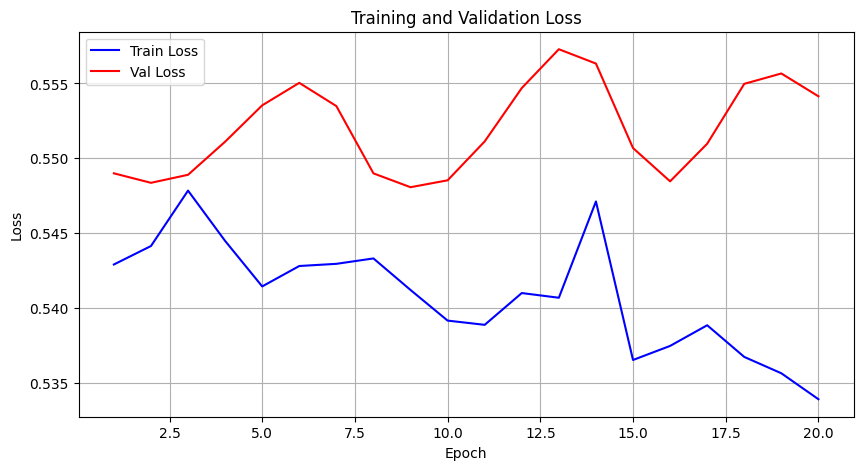

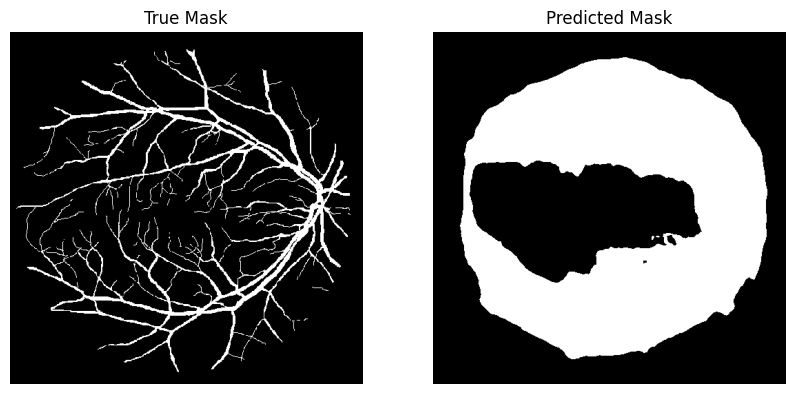

In [20]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(20):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Calculate IoU and Dice
    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)

pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Epoch 1 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 1: Train Loss=0.5474, Val Loss=0.5564, IoU=0.1477, Dice=0.2574


Epoch 2 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 2: Train Loss=0.5346, Val Loss=0.5573, IoU=0.1486, Dice=0.2588


Epoch 3 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 3: Train Loss=0.5313, Val Loss=0.5531, IoU=0.1477, Dice=0.2574


Epoch 4 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 4: Train Loss=0.5286, Val Loss=0.5564, IoU=0.1486, Dice=0.2587


Epoch 5 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 5: Train Loss=0.5321, Val Loss=0.5569, IoU=0.1483, Dice=0.2582


Epoch 6 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 6: Train Loss=0.5292, Val Loss=0.5558, IoU=0.1473, Dice=0.2568


Epoch 7 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 7: Train Loss=0.5305, Val Loss=0.5514, IoU=0.1464, Dice=0.2554


Epoch 8 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 8: Train Loss=0.5309, Val Loss=0.5535, IoU=0.1480, Dice=0.2578


Epoch 9 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 9: Train Loss=0.5323, Val Loss=0.5588, IoU=0.1495, Dice=0.2601


Epoch 10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 10: Train Loss=0.5281, Val Loss=0.5522, IoU=0.1459, Dice=0.2547


Epoch 11 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 11: Train Loss=0.5265, Val Loss=0.5550, IoU=0.1470, Dice=0.2563


Epoch 12 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 12: Train Loss=0.5283, Val Loss=0.5587, IoU=0.1497, Dice=0.2604


Epoch 13 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 13: Train Loss=0.5260, Val Loss=0.5570, IoU=0.1499, Dice=0.2608


Epoch 14 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 14: Train Loss=0.5312, Val Loss=0.5529, IoU=0.1485, Dice=0.2587


Epoch 15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 15: Train Loss=0.5295, Val Loss=0.5541, IoU=0.1478, Dice=0.2575


Epoch 16 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 16: Train Loss=0.5248, Val Loss=0.5546, IoU=0.1478, Dice=0.2575


Epoch 17 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 17: Train Loss=0.5245, Val Loss=0.5573, IoU=0.1488, Dice=0.2591


Epoch 18 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 18: Train Loss=0.5224, Val Loss=0.5598, IoU=0.1494, Dice=0.2600


Epoch 19 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 19: Train Loss=0.5220, Val Loss=0.5608, IoU=0.1507, Dice=0.2619


Epoch 20 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 20: Train Loss=0.5246, Val Loss=0.5538, IoU=0.1483, Dice=0.2583


Epoch 21 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 21: Train Loss=0.5193, Val Loss=0.5549, IoU=0.1491, Dice=0.2595


Epoch 22 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 22: Train Loss=0.5273, Val Loss=0.5541, IoU=0.1491, Dice=0.2595


Epoch 23 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 23: Train Loss=0.5224, Val Loss=0.5504, IoU=0.1482, Dice=0.2581


Epoch 24 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 24: Train Loss=0.5240, Val Loss=0.5529, IoU=0.1492, Dice=0.2597


Epoch 25 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 25: Train Loss=0.5197, Val Loss=0.5630, IoU=0.1520, Dice=0.2639


Epoch 26 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 26: Train Loss=0.5216, Val Loss=0.5574, IoU=0.1500, Dice=0.2609


Epoch 27 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 27: Train Loss=0.5171, Val Loss=0.5547, IoU=0.1491, Dice=0.2595


Epoch 28 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 28: Train Loss=0.5187, Val Loss=0.5533, IoU=0.1475, Dice=0.2571


Epoch 29 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 29: Train Loss=0.5182, Val Loss=0.5534, IoU=0.1472, Dice=0.2567


Epoch 30 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 30: Train Loss=0.5169, Val Loss=0.5581, IoU=0.1502, Dice=0.2612


Epoch 31 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 31: Train Loss=0.5171, Val Loss=0.5585, IoU=0.1518, Dice=0.2636


Epoch 32 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 32: Train Loss=0.5257, Val Loss=0.5502, IoU=0.1477, Dice=0.2574


Epoch 33 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 33: Train Loss=0.5194, Val Loss=0.5543, IoU=0.1489, Dice=0.2592


Epoch 34 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 34: Train Loss=0.5161, Val Loss=0.5618, IoU=0.1506, Dice=0.2618


Epoch 35 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 35: Train Loss=0.5168, Val Loss=0.5591, IoU=0.1507, Dice=0.2619


Epoch 36 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 36: Train Loss=0.5196, Val Loss=0.5542, IoU=0.1490, Dice=0.2594


Epoch 37 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 37: Train Loss=0.5147, Val Loss=0.5555, IoU=0.1496, Dice=0.2603


Epoch 38 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 38: Train Loss=0.5132, Val Loss=0.5592, IoU=0.1502, Dice=0.2612


Epoch 39 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 39: Train Loss=0.5193, Val Loss=0.5523, IoU=0.1471, Dice=0.2564


Epoch 40 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 40: Train Loss=0.5175, Val Loss=0.5531, IoU=0.1475, Dice=0.2571


Epoch 41 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 41: Train Loss=0.5144, Val Loss=0.5574, IoU=0.1505, Dice=0.2617


Epoch 42 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 42: Train Loss=0.5156, Val Loss=0.5542, IoU=0.1497, Dice=0.2605


Epoch 43 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 43: Train Loss=0.5115, Val Loss=0.5526, IoU=0.1488, Dice=0.2590


Epoch 44 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 44: Train Loss=0.5095, Val Loss=0.5589, IoU=0.1504, Dice=0.2615


Epoch 45 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 45: Train Loss=0.5182, Val Loss=0.5595, IoU=0.1505, Dice=0.2616


Epoch 46 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch 46: Train Loss=0.5132, Val Loss=0.5548, IoU=0.1485, Dice=0.2585


Epoch 47 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 47: Train Loss=0.5160, Val Loss=0.5579, IoU=0.1501, Dice=0.2610


Epoch 48 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 48: Train Loss=0.5150, Val Loss=0.5590, IoU=0.1511, Dice=0.2625


Epoch 49 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 49: Train Loss=0.5127, Val Loss=0.5566, IoU=0.1502, Dice=0.2612


Epoch 50 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-21-ac1c3cc41851>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 50: Train Loss=0.5086, Val Loss=0.5590, IoU=0.1513, Dice=0.2629


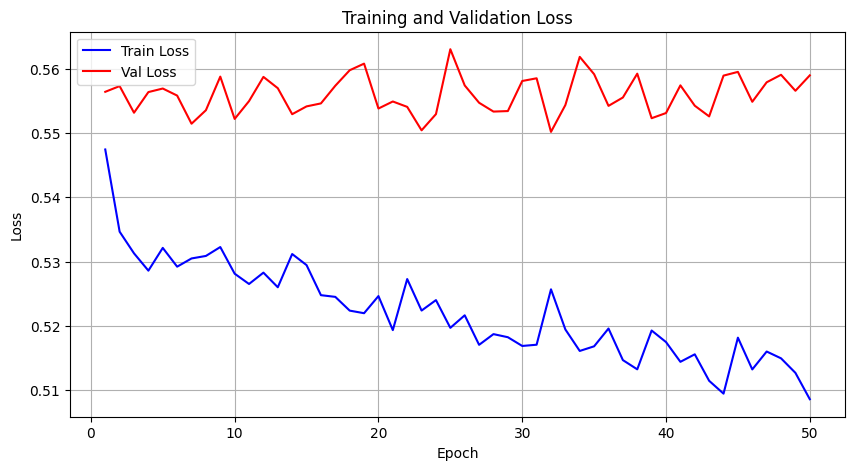

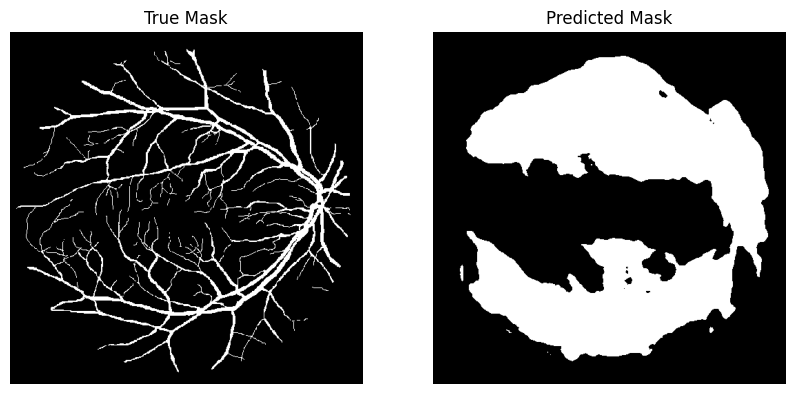

In [21]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)

pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Epoch 1 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 1: Train Loss=0.5104, Val Loss=0.5545, IoU=0.1495, Dice=0.2601


Epoch 2 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 2: Train Loss=0.5060, Val Loss=0.5539, IoU=0.1488, Dice=0.2590


Epoch 3 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 3: Train Loss=0.5140, Val Loss=0.5587, IoU=0.1504, Dice=0.2615


Epoch 4 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 4: Train Loss=0.5058, Val Loss=0.5601, IoU=0.1507, Dice=0.2619


Epoch 5 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 5: Train Loss=0.5130, Val Loss=0.5525, IoU=0.1466, Dice=0.2558


Epoch 6 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 6: Train Loss=0.5136, Val Loss=0.5517, IoU=0.1462, Dice=0.2551


Epoch 7 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 7: Train Loss=0.5102, Val Loss=0.5645, IoU=0.1515, Dice=0.2631


Epoch 8 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 8: Train Loss=0.5051, Val Loss=0.5575, IoU=0.1506, Dice=0.2618


Epoch 9 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 9: Train Loss=0.5052, Val Loss=0.5499, IoU=0.1475, Dice=0.2571


Epoch 10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 10: Train Loss=0.5100, Val Loss=0.5484, IoU=0.1471, Dice=0.2564


Epoch 11 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 11: Train Loss=0.5076, Val Loss=0.5536, IoU=0.1499, Dice=0.2607


Epoch 12 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 12: Train Loss=0.5123, Val Loss=0.5530, IoU=0.1486, Dice=0.2588


Epoch 13 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 13: Train Loss=0.5051, Val Loss=0.5561, IoU=0.1490, Dice=0.2594


Epoch 14 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 14: Train Loss=0.5071, Val Loss=0.5613, IoU=0.1505, Dice=0.2616


Epoch 15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 15: Train Loss=0.5097, Val Loss=0.5617, IoU=0.1504, Dice=0.2615


Epoch 16 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 16: Train Loss=0.5093, Val Loss=0.5534, IoU=0.1482, Dice=0.2582


Epoch 17 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 17: Train Loss=0.5054, Val Loss=0.5544, IoU=0.1474, Dice=0.2570


Epoch 18 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 18: Train Loss=0.5057, Val Loss=0.5539, IoU=0.1479, Dice=0.2577


Epoch 19 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 19: Train Loss=0.5090, Val Loss=0.5528, IoU=0.1483, Dice=0.2582


Epoch 20 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 20: Train Loss=0.5078, Val Loss=0.5557, IoU=0.1494, Dice=0.2599


Epoch 21 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 21: Train Loss=0.5025, Val Loss=0.5609, IoU=0.1509, Dice=0.2622


Epoch 22 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 22: Train Loss=0.5043, Val Loss=0.5542, IoU=0.1494, Dice=0.2599


Epoch 23 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 23: Train Loss=0.5074, Val Loss=0.5518, IoU=0.1483, Dice=0.2583


Epoch 24 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 24: Train Loss=0.4988, Val Loss=0.5565, IoU=0.1498, Dice=0.2606


Epoch 25 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 25: Train Loss=0.4989, Val Loss=0.5598, IoU=0.1520, Dice=0.2639


Epoch 26 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 26: Train Loss=0.4996, Val Loss=0.5545, IoU=0.1497, Dice=0.2604


Epoch 27 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 27: Train Loss=0.5062, Val Loss=0.5521, IoU=0.1480, Dice=0.2578


Epoch 28 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 28: Train Loss=0.5044, Val Loss=0.5602, IoU=0.1516, Dice=0.2632


Epoch 29 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch 29: Train Loss=0.5117, Val Loss=0.5665, IoU=0.1535, Dice=0.2661


Epoch 30 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 30: Train Loss=0.5054, Val Loss=0.5532, IoU=0.1503, Dice=0.2614


Epoch 31 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Epoch 31: Train Loss=0.5018, Val Loss=0.5508, IoU=0.1439, Dice=0.2517


Epoch 32 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 32: Train Loss=0.5009, Val Loss=0.5546, IoU=0.1481, Dice=0.2580


Epoch 33 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 33: Train Loss=0.5021, Val Loss=0.5643, IoU=0.1518, Dice=0.2636


Epoch 34 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 34: Train Loss=0.4990, Val Loss=0.5590, IoU=0.1509, Dice=0.2623


Epoch 35 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch 35: Train Loss=0.4980, Val Loss=0.5524, IoU=0.1493, Dice=0.2598


Epoch 36 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 36: Train Loss=0.4962, Val Loss=0.5563, IoU=0.1512, Dice=0.2626


Epoch 37 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 37: Train Loss=0.5021, Val Loss=0.5549, IoU=0.1508, Dice=0.2620


Epoch 38 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 38: Train Loss=0.4972, Val Loss=0.5491, IoU=0.1480, Dice=0.2578


Epoch 39 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 39: Train Loss=0.4994, Val Loss=0.5513, IoU=0.1496, Dice=0.2602


Epoch 40 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 40: Train Loss=0.4961, Val Loss=0.5578, IoU=0.1514, Dice=0.2630


Epoch 41 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 41: Train Loss=0.4960, Val Loss=0.5589, IoU=0.1516, Dice=0.2632


Epoch 42 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 42: Train Loss=0.4986, Val Loss=0.5520, IoU=0.1486, Dice=0.2587


Epoch 43 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 43: Train Loss=0.4965, Val Loss=0.5487, IoU=0.1478, Dice=0.2576


Epoch 44 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 44: Train Loss=0.4956, Val Loss=0.5540, IoU=0.1503, Dice=0.2613


Epoch 45 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 45: Train Loss=0.4995, Val Loss=0.5595, IoU=0.1523, Dice=0.2643


Epoch 46 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 46: Train Loss=0.4981, Val Loss=0.5572, IoU=0.1508, Dice=0.2621


Epoch 47 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 47: Train Loss=0.4947, Val Loss=0.5550, IoU=0.1486, Dice=0.2588


Epoch 48 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 48: Train Loss=0.4934, Val Loss=0.5579, IoU=0.1503, Dice=0.2613


Epoch 49 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 49: Train Loss=0.4935, Val Loss=0.5597, IoU=0.1488, Dice=0.2591


Epoch 50 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 50: Train Loss=0.4941, Val Loss=0.5576, IoU=0.1479, Dice=0.2576


Epoch 51 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 51: Train Loss=0.4915, Val Loss=0.5600, IoU=0.1504, Dice=0.2615


Epoch 52 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 52: Train Loss=0.4971, Val Loss=0.5579, IoU=0.1485, Dice=0.2587


Epoch 53 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 53: Train Loss=0.4921, Val Loss=0.5599, IoU=0.1508, Dice=0.2621


Epoch 54 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 54: Train Loss=0.4976, Val Loss=0.5555, IoU=0.1503, Dice=0.2613


Epoch 55 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 55: Train Loss=0.4930, Val Loss=0.5556, IoU=0.1493, Dice=0.2599


Epoch 56 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 56: Train Loss=0.4913, Val Loss=0.5575, IoU=0.1498, Dice=0.2605


Epoch 57 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 57: Train Loss=0.4881, Val Loss=0.5590, IoU=0.1512, Dice=0.2627


Epoch 58 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 58: Train Loss=0.4925, Val Loss=0.5547, IoU=0.1499, Dice=0.2607


Epoch 59 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 59: Train Loss=0.4936, Val Loss=0.5545, IoU=0.1499, Dice=0.2606


Epoch 60 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 60: Train Loss=0.4908, Val Loss=0.5560, IoU=0.1480, Dice=0.2579


Epoch 61 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 61: Train Loss=0.4922, Val Loss=0.5592, IoU=0.1478, Dice=0.2575


Epoch 62 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 62: Train Loss=0.4914, Val Loss=0.5566, IoU=0.1482, Dice=0.2581


Epoch 63 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 63: Train Loss=0.4931, Val Loss=0.5522, IoU=0.1474, Dice=0.2570


Epoch 64 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch 64: Train Loss=0.4929, Val Loss=0.5525, IoU=0.1497, Dice=0.2603


Epoch 65 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 65: Train Loss=0.4861, Val Loss=0.5566, IoU=0.1500, Dice=0.2608


Epoch 66 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 66: Train Loss=0.4902, Val Loss=0.5638, IoU=0.1501, Dice=0.2610


Epoch 67 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 67: Train Loss=0.4958, Val Loss=0.5637, IoU=0.1513, Dice=0.2628


Epoch 68 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 68: Train Loss=0.4899, Val Loss=0.5575, IoU=0.1484, Dice=0.2585


Epoch 69 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 69: Train Loss=0.4898, Val Loss=0.5571, IoU=0.1481, Dice=0.2580


Epoch 70 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 70: Train Loss=0.4869, Val Loss=0.5642, IoU=0.1519, Dice=0.2637


Epoch 71 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 71: Train Loss=0.4891, Val Loss=0.5607, IoU=0.1492, Dice=0.2596


Epoch 72 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 72: Train Loss=0.4844, Val Loss=0.5553, IoU=0.1463, Dice=0.2552


Epoch 73 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 73: Train Loss=0.4905, Val Loss=0.5623, IoU=0.1487, Dice=0.2589


Epoch 74 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 74: Train Loss=0.4936, Val Loss=0.5632, IoU=0.1494, Dice=0.2600


Epoch 75 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 75: Train Loss=0.4810, Val Loss=0.5548, IoU=0.1476, Dice=0.2572


Epoch 76 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 76: Train Loss=0.4843, Val Loss=0.5539, IoU=0.1479, Dice=0.2577


Epoch 77 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 77: Train Loss=0.4807, Val Loss=0.5567, IoU=0.1491, Dice=0.2595


Epoch 78 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 78: Train Loss=0.4838, Val Loss=0.5637, IoU=0.1515, Dice=0.2631


Epoch 79 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 79: Train Loss=0.4875, Val Loss=0.5633, IoU=0.1518, Dice=0.2636


Epoch 80 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 80: Train Loss=0.4794, Val Loss=0.5601, IoU=0.1496, Dice=0.2603


Epoch 81 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 81: Train Loss=0.4866, Val Loss=0.5558, IoU=0.1487, Dice=0.2588


Epoch 82 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 82: Train Loss=0.4844, Val Loss=0.5565, IoU=0.1493, Dice=0.2598


Epoch 83 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 83: Train Loss=0.4836, Val Loss=0.5585, IoU=0.1488, Dice=0.2590


Epoch 84 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 84: Train Loss=0.4867, Val Loss=0.5588, IoU=0.1482, Dice=0.2581


Epoch 85 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 85: Train Loss=0.4822, Val Loss=0.5574, IoU=0.1483, Dice=0.2583


Epoch 86 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 86: Train Loss=0.4843, Val Loss=0.5568, IoU=0.1481, Dice=0.2580


Epoch 87 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 87: Train Loss=0.4790, Val Loss=0.5620, IoU=0.1500, Dice=0.2609


Epoch 88 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 88: Train Loss=0.4800, Val Loss=0.5609, IoU=0.1483, Dice=0.2582


Epoch 89 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 89: Train Loss=0.4803, Val Loss=0.5606, IoU=0.1480, Dice=0.2579


Epoch 90 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 90: Train Loss=0.4808, Val Loss=0.5630, IoU=0.1492, Dice=0.2597


Epoch 91 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 91: Train Loss=0.4797, Val Loss=0.5690, IoU=0.1503, Dice=0.2613


Epoch 92 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 92: Train Loss=0.4754, Val Loss=0.5651, IoU=0.1507, Dice=0.2619


Epoch 93 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 93: Train Loss=0.4776, Val Loss=0.5615, IoU=0.1493, Dice=0.2598


Epoch 94 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 94: Train Loss=0.4761, Val Loss=0.5613, IoU=0.1475, Dice=0.2571


Epoch 95 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 95: Train Loss=0.4756, Val Loss=0.5634, IoU=0.1482, Dice=0.2581


Epoch 96 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 96: Train Loss=0.4748, Val Loss=0.5646, IoU=0.1494, Dice=0.2600


Epoch 97 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 97: Train Loss=0.4715, Val Loss=0.5670, IoU=0.1512, Dice=0.2627


Epoch 98 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 98: Train Loss=0.4803, Val Loss=0.5677, IoU=0.1518, Dice=0.2635


Epoch 99 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 99: Train Loss=0.4777, Val Loss=0.5602, IoU=0.1502, Dice=0.2612


Epoch 100 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 100: Train Loss=0.4748, Val Loss=0.5631, IoU=0.1497, Dice=0.2604


Epoch 101 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 101 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 101 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 101: Train Loss=0.4756, Val Loss=0.5630, IoU=0.1486, Dice=0.2588


Epoch 102 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 102 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 102 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 102: Train Loss=0.4796, Val Loss=0.5707, IoU=0.1508, Dice=0.2620


Epoch 103 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 103 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 103 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 103: Train Loss=0.4762, Val Loss=0.5666, IoU=0.1502, Dice=0.2611


Epoch 104 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 104 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 104 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 104: Train Loss=0.4796, Val Loss=0.5721, IoU=0.1499, Dice=0.2607


Epoch 105 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 105 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 105 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 105: Train Loss=0.4750, Val Loss=0.5662, IoU=0.1499, Dice=0.2607


Epoch 106 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 106 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 106 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 106: Train Loss=0.4742, Val Loss=0.5685, IoU=0.1508, Dice=0.2621


Epoch 107 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 107 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 107 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 107: Train Loss=0.4749, Val Loss=0.5623, IoU=0.1493, Dice=0.2598


Epoch 108 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 108 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 108 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 108: Train Loss=0.4736, Val Loss=0.5698, IoU=0.1501, Dice=0.2611


Epoch 109 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 109 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 109 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 109: Train Loss=0.4763, Val Loss=0.5680, IoU=0.1493, Dice=0.2598


Epoch 110 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 110 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 110 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 110: Train Loss=0.4720, Val Loss=0.5658, IoU=0.1488, Dice=0.2590


Epoch 111 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 111 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 111 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 111: Train Loss=0.4778, Val Loss=0.5674, IoU=0.1516, Dice=0.2633


Epoch 112 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 112 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 112 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 112: Train Loss=0.4718, Val Loss=0.5628, IoU=0.1503, Dice=0.2614


Epoch 113 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 113 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 113 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 113: Train Loss=0.4739, Val Loss=0.5625, IoU=0.1497, Dice=0.2604


Epoch 114 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 114 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 114 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 114: Train Loss=0.4753, Val Loss=0.5718, IoU=0.1497, Dice=0.2604


Epoch 115 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 115 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 115 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 115: Train Loss=0.4669, Val Loss=0.5733, IoU=0.1494, Dice=0.2600


Epoch 116 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 116 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 116 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 116: Train Loss=0.4730, Val Loss=0.5735, IoU=0.1489, Dice=0.2592


Epoch 117 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 117 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 117 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 117: Train Loss=0.4732, Val Loss=0.5627, IoU=0.1478, Dice=0.2575


Epoch 118 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 118 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 118 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 118: Train Loss=0.4698, Val Loss=0.5677, IoU=0.1507, Dice=0.2619


Epoch 119 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 119 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 119 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 119: Train Loss=0.4659, Val Loss=0.5728, IoU=0.1510, Dice=0.2624


Epoch 120 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 120 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 120 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 120: Train Loss=0.4749, Val Loss=0.5605, IoU=0.1476, Dice=0.2573


Epoch 121 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 121 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 121 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 121: Train Loss=0.4724, Val Loss=0.5648, IoU=0.1489, Dice=0.2591


Epoch 122 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 122 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 122 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 122: Train Loss=0.4733, Val Loss=0.5788, IoU=0.1499, Dice=0.2607


Epoch 123 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 123 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 123 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 123: Train Loss=0.4687, Val Loss=0.5762, IoU=0.1489, Dice=0.2593


Epoch 124 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 124 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 124 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 124: Train Loss=0.4719, Val Loss=0.5713, IoU=0.1505, Dice=0.2616


Epoch 125 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 125 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 125 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 125: Train Loss=0.4739, Val Loss=0.5677, IoU=0.1493, Dice=0.2598


Epoch 126 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 126 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 126 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 126: Train Loss=0.4697, Val Loss=0.5780, IoU=0.1491, Dice=0.2595


Epoch 127 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 127 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 127 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 127: Train Loss=0.4615, Val Loss=0.5899, IoU=0.1466, Dice=0.2557


Epoch 128 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 128 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 128 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 128: Train Loss=0.4659, Val Loss=0.5856, IoU=0.1492, Dice=0.2596


Epoch 129 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 129 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 129 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 129: Train Loss=0.4651, Val Loss=0.5739, IoU=0.1488, Dice=0.2590


Epoch 130 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 130 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 130 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 130: Train Loss=0.4634, Val Loss=0.5779, IoU=0.1486, Dice=0.2587


Epoch 131 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 131 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 131 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 131: Train Loss=0.4650, Val Loss=0.5851, IoU=0.1493, Dice=0.2597


Epoch 132 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 132 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 132 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 132: Train Loss=0.4671, Val Loss=0.5705, IoU=0.1495, Dice=0.2602


Epoch 133 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 133 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 133 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 133: Train Loss=0.4724, Val Loss=0.5683, IoU=0.1495, Dice=0.2601


Epoch 134 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 134 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 134 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 134: Train Loss=0.4614, Val Loss=0.5698, IoU=0.1484, Dice=0.2584


Epoch 135 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 135 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 135 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 135: Train Loss=0.4611, Val Loss=0.5788, IoU=0.1498, Dice=0.2605


Epoch 136 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 136 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 136 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 136: Train Loss=0.4590, Val Loss=0.5782, IoU=0.1502, Dice=0.2611


Epoch 137 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 137 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 137 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 137: Train Loss=0.4621, Val Loss=0.5719, IoU=0.1475, Dice=0.2571


Epoch 138 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 138 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 138 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 138: Train Loss=0.4714, Val Loss=0.5789, IoU=0.1493, Dice=0.2599


Epoch 139 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 139 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 139 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 139: Train Loss=0.4535, Val Loss=0.5785, IoU=0.1502, Dice=0.2612


Epoch 140 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 140 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 140 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 140: Train Loss=0.4620, Val Loss=0.5848, IoU=0.1501, Dice=0.2610


Epoch 141 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 141 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 141 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 141: Train Loss=0.4666, Val Loss=0.5837, IoU=0.1503, Dice=0.2613


Epoch 142 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 142 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 142 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 142: Train Loss=0.4582, Val Loss=0.5760, IoU=0.1503, Dice=0.2614


Epoch 143 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 143 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 143 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 143: Train Loss=0.4575, Val Loss=0.5735, IoU=0.1496, Dice=0.2603


Epoch 144 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 144 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 144 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 144: Train Loss=0.4592, Val Loss=0.5750, IoU=0.1487, Dice=0.2590


Epoch 145 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 145 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 145 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 145: Train Loss=0.4583, Val Loss=0.5819, IoU=0.1488, Dice=0.2591


Epoch 146 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 146 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 146 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 146: Train Loss=0.4626, Val Loss=0.5907, IoU=0.1493, Dice=0.2598


Epoch 147 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 147 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 147 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 147: Train Loss=0.4658, Val Loss=0.5794, IoU=0.1496, Dice=0.2602


Epoch 148 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 148 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 148 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 148: Train Loss=0.4545, Val Loss=0.5779, IoU=0.1489, Dice=0.2592


Epoch 149 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 149 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 149 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 149: Train Loss=0.4546, Val Loss=0.5929, IoU=0.1479, Dice=0.2577


Epoch 150 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 150 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-22-5311906b0f4e>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 150 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 150: Train Loss=0.4578, Val Loss=0.5942, IoU=0.1473, Dice=0.2568


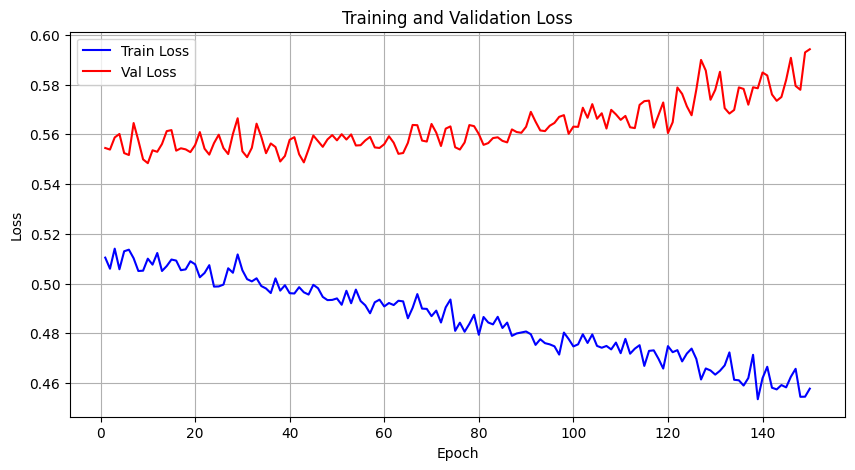

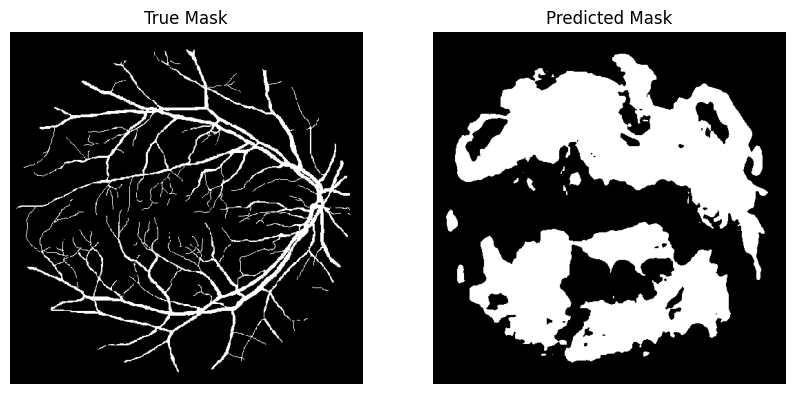

In [22]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(150):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)


pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Epoch 1 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 1: Train Loss=0.4688, Val Loss=0.5822, IoU=0.1486, Dice=0.2587


Epoch 2 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 2: Train Loss=0.4550, Val Loss=0.5837, IoU=0.1517, Dice=0.2634


Epoch 3 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 3: Train Loss=0.4543, Val Loss=0.5959, IoU=0.1497, Dice=0.2604


Epoch 4 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 4: Train Loss=0.4550, Val Loss=0.5879, IoU=0.1471, Dice=0.2565


Epoch 5 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 5: Train Loss=0.4587, Val Loss=0.5765, IoU=0.1481, Dice=0.2580


Epoch 6 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch 6: Train Loss=0.4515, Val Loss=0.5801, IoU=0.1491, Dice=0.2594


Epoch 7 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 7: Train Loss=0.4522, Val Loss=0.5868, IoU=0.1485, Dice=0.2587


Epoch 8 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 8: Train Loss=0.4642, Val Loss=0.5789, IoU=0.1497, Dice=0.2603


Epoch 9 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 9: Train Loss=0.4602, Val Loss=0.5678, IoU=0.1479, Dice=0.2577


Epoch 10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 10: Train Loss=0.4552, Val Loss=0.5741, IoU=0.1500, Dice=0.2609


Epoch 11 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 11: Train Loss=0.4576, Val Loss=0.5830, IoU=0.1501, Dice=0.2610


Epoch 12 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 12: Train Loss=0.4537, Val Loss=0.5823, IoU=0.1489, Dice=0.2592


Epoch 13 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 13: Train Loss=0.4536, Val Loss=0.5965, IoU=0.1494, Dice=0.2599


Epoch 14 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 14: Train Loss=0.4492, Val Loss=0.5828, IoU=0.1507, Dice=0.2620


Epoch 15 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 15: Train Loss=0.4574, Val Loss=0.5831, IoU=0.1504, Dice=0.2615


Epoch 16 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 16: Train Loss=0.4572, Val Loss=0.5821, IoU=0.1498, Dice=0.2605


Epoch 17 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 17: Train Loss=0.4494, Val Loss=0.5879, IoU=0.1500, Dice=0.2609


Epoch 18 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 18: Train Loss=0.4516, Val Loss=0.5885, IoU=0.1499, Dice=0.2606


Epoch 19 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 19: Train Loss=0.4472, Val Loss=0.5836, IoU=0.1485, Dice=0.2585


Epoch 20 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 20: Train Loss=0.4563, Val Loss=0.5918, IoU=0.1476, Dice=0.2572


Epoch 21 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 21: Train Loss=0.4521, Val Loss=0.5927, IoU=0.1480, Dice=0.2578


Epoch 22 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 22: Train Loss=0.4491, Val Loss=0.5958, IoU=0.1480, Dice=0.2578


Epoch 23 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 23: Train Loss=0.4532, Val Loss=0.5981, IoU=0.1477, Dice=0.2574


Epoch 24 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 24: Train Loss=0.4553, Val Loss=0.5921, IoU=0.1473, Dice=0.2568


Epoch 25 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 25: Train Loss=0.4504, Val Loss=0.5887, IoU=0.1475, Dice=0.2570


Epoch 26 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 26: Train Loss=0.4452, Val Loss=0.6155, IoU=0.1475, Dice=0.2571


Epoch 27 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 27: Train Loss=0.4390, Val Loss=0.6233, IoU=0.1470, Dice=0.2564


Epoch 28 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 28: Train Loss=0.4519, Val Loss=0.5926, IoU=0.1493, Dice=0.2598


Epoch 29 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 29: Train Loss=0.4468, Val Loss=0.5883, IoU=0.1500, Dice=0.2609


Epoch 30 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 30: Train Loss=0.4451, Val Loss=0.6043, IoU=0.1494, Dice=0.2600


Epoch 31 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 31: Train Loss=0.4473, Val Loss=0.6044, IoU=0.1480, Dice=0.2579


Epoch 32 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 32: Train Loss=0.4446, Val Loss=0.5888, IoU=0.1491, Dice=0.2595


Epoch 33 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 33: Train Loss=0.4382, Val Loss=0.5959, IoU=0.1499, Dice=0.2608


Epoch 34 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 34: Train Loss=0.4409, Val Loss=0.6084, IoU=0.1488, Dice=0.2591


Epoch 35 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 35: Train Loss=0.4499, Val Loss=0.5923, IoU=0.1480, Dice=0.2579


Epoch 36 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 36: Train Loss=0.4412, Val Loss=0.5945, IoU=0.1486, Dice=0.2587


Epoch 37 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 37: Train Loss=0.4425, Val Loss=0.6093, IoU=0.1476, Dice=0.2573


Epoch 38 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 38: Train Loss=0.4423, Val Loss=0.6078, IoU=0.1465, Dice=0.2556


Epoch 39 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 39: Train Loss=0.4413, Val Loss=0.5978, IoU=0.1489, Dice=0.2592


Epoch 40 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 40: Train Loss=0.4473, Val Loss=0.5935, IoU=0.1498, Dice=0.2605


Epoch 41 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 41: Train Loss=0.4364, Val Loss=0.5924, IoU=0.1474, Dice=0.2569


Epoch 42 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 42: Train Loss=0.4507, Val Loss=0.5927, IoU=0.1454, Dice=0.2538


Epoch 43 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 43: Train Loss=0.4431, Val Loss=0.6068, IoU=0.1461, Dice=0.2549


Epoch 44 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 44: Train Loss=0.4503, Val Loss=0.6088, IoU=0.1491, Dice=0.2596


Epoch 45 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 45: Train Loss=0.4335, Val Loss=0.5992, IoU=0.1484, Dice=0.2585


Epoch 46 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 46: Train Loss=0.4401, Val Loss=0.6000, IoU=0.1466, Dice=0.2556


Epoch 47 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 47: Train Loss=0.4492, Val Loss=0.6214, IoU=0.1463, Dice=0.2552


Epoch 48 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 48: Train Loss=0.4403, Val Loss=0.6062, IoU=0.1468, Dice=0.2560


Epoch 49 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 49: Train Loss=0.4538, Val Loss=0.5939, IoU=0.1480, Dice=0.2578


Epoch 50 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 50: Train Loss=0.4329, Val Loss=0.5979, IoU=0.1486, Dice=0.2588


Epoch 51 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 51: Train Loss=0.4295, Val Loss=0.6157, IoU=0.1463, Dice=0.2552


Epoch 52 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 52: Train Loss=0.4409, Val Loss=0.6126, IoU=0.1453, Dice=0.2537


Epoch 53 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 53: Train Loss=0.4458, Val Loss=0.5971, IoU=0.1475, Dice=0.2570


Epoch 54 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 54: Train Loss=0.4322, Val Loss=0.6108, IoU=0.1493, Dice=0.2599


Epoch 55 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 55: Train Loss=0.4347, Val Loss=0.6168, IoU=0.1486, Dice=0.2587


Epoch 56 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 56: Train Loss=0.4372, Val Loss=0.6057, IoU=0.1474, Dice=0.2569


Epoch 57 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 57: Train Loss=0.4424, Val Loss=0.6025, IoU=0.1469, Dice=0.2562


Epoch 58 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 58: Train Loss=0.4299, Val Loss=0.6037, IoU=0.1474, Dice=0.2570


Epoch 59 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 59: Train Loss=0.4375, Val Loss=0.6084, IoU=0.1487, Dice=0.2589


Epoch 60 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 60: Train Loss=0.4489, Val Loss=0.6042, IoU=0.1476, Dice=0.2573


Epoch 61 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 61: Train Loss=0.4381, Val Loss=0.6137, IoU=0.1461, Dice=0.2549


Epoch 62 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 62: Train Loss=0.4428, Val Loss=0.6237, IoU=0.1461, Dice=0.2549


Epoch 63 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 63: Train Loss=0.4361, Val Loss=0.6130, IoU=0.1467, Dice=0.2559


Epoch 64 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 64: Train Loss=0.4404, Val Loss=0.6055, IoU=0.1477, Dice=0.2574


Epoch 65 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 65: Train Loss=0.4222, Val Loss=0.6202, IoU=0.1485, Dice=0.2587


Epoch 66 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 66: Train Loss=0.4431, Val Loss=0.6200, IoU=0.1487, Dice=0.2589


Epoch 67 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 67: Train Loss=0.4328, Val Loss=0.6083, IoU=0.1472, Dice=0.2566


Epoch 68 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 68: Train Loss=0.4261, Val Loss=0.6164, IoU=0.1463, Dice=0.2552


Epoch 69 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 69: Train Loss=0.4455, Val Loss=0.6070, IoU=0.1469, Dice=0.2562


Epoch 70 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 70: Train Loss=0.4307, Val Loss=0.6157, IoU=0.1493, Dice=0.2598


Epoch 71 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 71: Train Loss=0.4384, Val Loss=0.6176, IoU=0.1506, Dice=0.2618


Epoch 72 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 72: Train Loss=0.4315, Val Loss=0.6253, IoU=0.1496, Dice=0.2603


Epoch 73 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 73: Train Loss=0.4393, Val Loss=0.6113, IoU=0.1498, Dice=0.2606


Epoch 74 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 74: Train Loss=0.4300, Val Loss=0.6339, IoU=0.1489, Dice=0.2593


Epoch 75 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 75: Train Loss=0.4328, Val Loss=0.6315, IoU=0.1485, Dice=0.2586


Epoch 76 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 76: Train Loss=0.4348, Val Loss=0.6168, IoU=0.1505, Dice=0.2617


Epoch 77 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 77: Train Loss=0.4293, Val Loss=0.6194, IoU=0.1507, Dice=0.2619


Epoch 78 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 78: Train Loss=0.4229, Val Loss=0.6415, IoU=0.1476, Dice=0.2572


Epoch 79 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 79: Train Loss=0.4193, Val Loss=0.6172, IoU=0.1479, Dice=0.2577


Epoch 80 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch 80: Train Loss=0.4317, Val Loss=0.6174, IoU=0.1498, Dice=0.2605


Epoch 81 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 81: Train Loss=0.4262, Val Loss=0.6363, IoU=0.1485, Dice=0.2586


Epoch 82 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 82: Train Loss=0.4350, Val Loss=0.6468, IoU=0.1458, Dice=0.2545


Epoch 83 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 83: Train Loss=0.4354, Val Loss=0.6123, IoU=0.1485, Dice=0.2586


Epoch 84 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 84: Train Loss=0.4220, Val Loss=0.6077, IoU=0.1486, Dice=0.2588


Epoch 85 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 85: Train Loss=0.4352, Val Loss=0.6334, IoU=0.1485, Dice=0.2586


Epoch 86 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 86: Train Loss=0.4188, Val Loss=0.6426, IoU=0.1475, Dice=0.2571


Epoch 87 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 87: Train Loss=0.4258, Val Loss=0.6282, IoU=0.1505, Dice=0.2616


Epoch 88 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 88: Train Loss=0.4266, Val Loss=0.6238, IoU=0.1512, Dice=0.2626


Epoch 89 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 89: Train Loss=0.4177, Val Loss=0.6311, IoU=0.1486, Dice=0.2588


Epoch 90 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 90: Train Loss=0.4307, Val Loss=0.6207, IoU=0.1481, Dice=0.2580


Epoch 91 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 91: Train Loss=0.4217, Val Loss=0.6202, IoU=0.1492, Dice=0.2597


Epoch 92 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 92: Train Loss=0.4160, Val Loss=0.6450, IoU=0.1483, Dice=0.2583


Epoch 93 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 93: Train Loss=0.4265, Val Loss=0.6392, IoU=0.1495, Dice=0.2601


Epoch 94 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch 94: Train Loss=0.4164, Val Loss=0.6383, IoU=0.1509, Dice=0.2622


Epoch 95 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 95: Train Loss=0.4132, Val Loss=0.6380, IoU=0.1488, Dice=0.2590


Epoch 96 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 96: Train Loss=0.4208, Val Loss=0.6376, IoU=0.1474, Dice=0.2570


Epoch 97 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 97: Train Loss=0.4138, Val Loss=0.6314, IoU=0.1488, Dice=0.2590


Epoch 98 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 98: Train Loss=0.4235, Val Loss=0.6266, IoU=0.1503, Dice=0.2613


Epoch 99 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 99: Train Loss=0.4151, Val Loss=0.6319, IoU=0.1498, Dice=0.2606


Epoch 100 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 100: Train Loss=0.4180, Val Loss=0.6354, IoU=0.1493, Dice=0.2597


Epoch 101 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 101 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 101 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 101: Train Loss=0.4143, Val Loss=0.6172, IoU=0.1470, Dice=0.2563


Epoch 102 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 102 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 102 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 102: Train Loss=0.4242, Val Loss=0.6436, IoU=0.1477, Dice=0.2574


Epoch 103 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 103 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 103 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 103: Train Loss=0.4188, Val Loss=0.6404, IoU=0.1487, Dice=0.2589


Epoch 104 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 104 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 104 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 104: Train Loss=0.4199, Val Loss=0.6098, IoU=0.1490, Dice=0.2593


Epoch 105 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 105 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 105 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 105: Train Loss=0.4134, Val Loss=0.6289, IoU=0.1496, Dice=0.2603


Epoch 106 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 106 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 106 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 106: Train Loss=0.4091, Val Loss=0.6474, IoU=0.1477, Dice=0.2574


Epoch 107 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 107 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 107 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 107: Train Loss=0.4234, Val Loss=0.6403, IoU=0.1459, Dice=0.2547


Epoch 108 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 108 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 108 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 108: Train Loss=0.4297, Val Loss=0.6406, IoU=0.1467, Dice=0.2559


Epoch 109 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 109 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 109 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 109: Train Loss=0.4347, Val Loss=0.6218, IoU=0.1473, Dice=0.2567


Epoch 110 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 110 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 110 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 110: Train Loss=0.4177, Val Loss=0.6372, IoU=0.1451, Dice=0.2534


Epoch 111 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 111 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 111 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 111: Train Loss=0.4105, Val Loss=0.6580, IoU=0.1456, Dice=0.2542


Epoch 112 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 112 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 112 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 112: Train Loss=0.4057, Val Loss=0.6564, IoU=0.1475, Dice=0.2571


Epoch 113 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 113 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 113 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 113: Train Loss=0.4104, Val Loss=0.6537, IoU=0.1469, Dice=0.2562


Epoch 114 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 114 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 114 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 114: Train Loss=0.4079, Val Loss=0.6497, IoU=0.1478, Dice=0.2575


Epoch 115 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 115 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 115 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 115: Train Loss=0.4132, Val Loss=0.6498, IoU=0.1496, Dice=0.2602


Epoch 116 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 116 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 116 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 116: Train Loss=0.4074, Val Loss=0.6526, IoU=0.1487, Dice=0.2589


Epoch 117 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 117 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 117 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 117: Train Loss=0.4153, Val Loss=0.6451, IoU=0.1446, Dice=0.2526


Epoch 118 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 118 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 118 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 118: Train Loss=0.4102, Val Loss=0.6629, IoU=0.1474, Dice=0.2569


Epoch 119 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 119 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 119 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 119: Train Loss=0.4137, Val Loss=0.6515, IoU=0.1475, Dice=0.2570


Epoch 120 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 120 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 120 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 120: Train Loss=0.4141, Val Loss=0.6213, IoU=0.1463, Dice=0.2552


Epoch 121 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 121 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 121 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 121: Train Loss=0.4034, Val Loss=0.6553, IoU=0.1474, Dice=0.2569


Epoch 122 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 122 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 122 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 122: Train Loss=0.4151, Val Loss=0.6622, IoU=0.1477, Dice=0.2574


Epoch 123 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 123 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 123 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 123: Train Loss=0.4161, Val Loss=0.6379, IoU=0.1475, Dice=0.2571


Epoch 124 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 124 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 124 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 124: Train Loss=0.4151, Val Loss=0.6633, IoU=0.1482, Dice=0.2582


Epoch 125 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 125 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 125 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 125: Train Loss=0.4106, Val Loss=0.6808, IoU=0.1466, Dice=0.2558


Epoch 126 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 126 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 126 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 126: Train Loss=0.4255, Val Loss=0.6456, IoU=0.1471, Dice=0.2565


Epoch 127 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 127 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 127 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 127: Train Loss=0.4107, Val Loss=0.6521, IoU=0.1478, Dice=0.2575


Epoch 128 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 128 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 128 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 128: Train Loss=0.4141, Val Loss=0.6508, IoU=0.1477, Dice=0.2573


Epoch 129 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 129 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 129 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 129: Train Loss=0.4242, Val Loss=0.6348, IoU=0.1496, Dice=0.2602


Epoch 130 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 130 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 130 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 130: Train Loss=0.4117, Val Loss=0.6249, IoU=0.1478, Dice=0.2576


Epoch 131 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 131 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 131 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 131: Train Loss=0.4035, Val Loss=0.6530, IoU=0.1458, Dice=0.2545


Epoch 132 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 132 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 132 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 132: Train Loss=0.4035, Val Loss=0.6637, IoU=0.1464, Dice=0.2554


Epoch 133 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 133 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 133 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 133: Train Loss=0.4140, Val Loss=0.6505, IoU=0.1472, Dice=0.2566


Epoch 134 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 134 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 134 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 134: Train Loss=0.4053, Val Loss=0.6428, IoU=0.1467, Dice=0.2558


Epoch 135 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 135 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 135 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 135: Train Loss=0.3931, Val Loss=0.6634, IoU=0.1477, Dice=0.2574


Epoch 136 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 136 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 136 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 136: Train Loss=0.4119, Val Loss=0.6646, IoU=0.1471, Dice=0.2565


Epoch 137 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 137 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 137 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 137: Train Loss=0.3948, Val Loss=0.6627, IoU=0.1454, Dice=0.2539


Epoch 138 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 138 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 138 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 138: Train Loss=0.4054, Val Loss=0.6729, IoU=0.1456, Dice=0.2542


Epoch 139 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 139 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 139 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 139: Train Loss=0.3913, Val Loss=0.6710, IoU=0.1462, Dice=0.2551


Epoch 140 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 140 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 140 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 140: Train Loss=0.3902, Val Loss=0.6824, IoU=0.1450, Dice=0.2533


Epoch 141 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 141 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 141 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 141: Train Loss=0.4173, Val Loss=0.6788, IoU=0.1454, Dice=0.2539


Epoch 142 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 142 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 142 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 142: Train Loss=0.4121, Val Loss=0.6859, IoU=0.1467, Dice=0.2559


Epoch 143 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 143 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 143 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 143: Train Loss=0.3975, Val Loss=0.6624, IoU=0.1455, Dice=0.2540


Epoch 144 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 144 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 144 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 144: Train Loss=0.4067, Val Loss=0.6809, IoU=0.1445, Dice=0.2525


Epoch 145 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 145 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 145 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 145: Train Loss=0.4065, Val Loss=0.6929, IoU=0.1449, Dice=0.2532


Epoch 146 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 146 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 146 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 146: Train Loss=0.3946, Val Loss=0.6737, IoU=0.1450, Dice=0.2533


Epoch 147 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 147 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 147 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 147: Train Loss=0.4008, Val Loss=0.6771, IoU=0.1459, Dice=0.2547


Epoch 148 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 148 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 148 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 148: Train Loss=0.4144, Val Loss=0.6672, IoU=0.1453, Dice=0.2538


Epoch 149 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 149 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 149 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 149: Train Loss=0.4134, Val Loss=0.6684, IoU=0.1447, Dice=0.2527


Epoch 150 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 150 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 150 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 150: Train Loss=0.4064, Val Loss=0.6725, IoU=0.1443, Dice=0.2522


Epoch 151 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 151 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 151 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 151: Train Loss=0.4108, Val Loss=0.6594, IoU=0.1458, Dice=0.2545


Epoch 152 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 152 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 152 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 152: Train Loss=0.3991, Val Loss=0.6500, IoU=0.1449, Dice=0.2531


Epoch 153 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 153 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 153 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 153: Train Loss=0.3942, Val Loss=0.6765, IoU=0.1429, Dice=0.2501


Epoch 154 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 154 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 154 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 154: Train Loss=0.3919, Val Loss=0.6924, IoU=0.1429, Dice=0.2500


Epoch 155 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 155 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 155 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 155: Train Loss=0.4094, Val Loss=0.6760, IoU=0.1440, Dice=0.2517


Epoch 156 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 156 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 156 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 156: Train Loss=0.3977, Val Loss=0.6735, IoU=0.1449, Dice=0.2532


Epoch 157 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 157 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 157 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 157: Train Loss=0.3960, Val Loss=0.6929, IoU=0.1445, Dice=0.2525


Epoch 158 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 158 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 158 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 158: Train Loss=0.4039, Val Loss=0.6667, IoU=0.1452, Dice=0.2536


Epoch 159 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 159 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 159 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 159: Train Loss=0.3985, Val Loss=0.6636, IoU=0.1468, Dice=0.2560


Epoch 160 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 160 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 160 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 160: Train Loss=0.4051, Val Loss=0.6903, IoU=0.1453, Dice=0.2537


Epoch 161 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 161 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 161 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 161: Train Loss=0.3980, Val Loss=0.7025, IoU=0.1438, Dice=0.2515


Epoch 162 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 162 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 162 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 162: Train Loss=0.3903, Val Loss=0.6910, IoU=0.1449, Dice=0.2532


Epoch 163 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 163 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 163 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 163: Train Loss=0.4006, Val Loss=0.6814, IoU=0.1458, Dice=0.2544


Epoch 164 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 164 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 164 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 164: Train Loss=0.3966, Val Loss=0.6851, IoU=0.1470, Dice=0.2563


Epoch 165 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 165 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 165 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 165: Train Loss=0.3755, Val Loss=0.6894, IoU=0.1459, Dice=0.2546


Epoch 166 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 166 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 166 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 166: Train Loss=0.3812, Val Loss=0.7026, IoU=0.1446, Dice=0.2527


Epoch 167 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 167 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 167 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 167: Train Loss=0.3871, Val Loss=0.6882, IoU=0.1455, Dice=0.2541


Epoch 168 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 168 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 168 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 168: Train Loss=0.4041, Val Loss=0.7039, IoU=0.1453, Dice=0.2537


Epoch 169 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 169 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 169 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 169: Train Loss=0.3959, Val Loss=0.6862, IoU=0.1445, Dice=0.2526


Epoch 170 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 170 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 170 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 170: Train Loss=0.4167, Val Loss=0.6513, IoU=0.1469, Dice=0.2562


Epoch 171 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 171 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 171 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 171: Train Loss=0.3930, Val Loss=0.6868, IoU=0.1462, Dice=0.2551


Epoch 172 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 172 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 172 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 172: Train Loss=0.3825, Val Loss=0.7291, IoU=0.1424, Dice=0.2492


Epoch 173 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 173 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 173 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 173: Train Loss=0.3839, Val Loss=0.7177, IoU=0.1431, Dice=0.2504


Epoch 174 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 174 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 174 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 174: Train Loss=0.4025, Val Loss=0.6790, IoU=0.1461, Dice=0.2550


Epoch 175 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 175 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 175 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 175: Train Loss=0.3823, Val Loss=0.6962, IoU=0.1455, Dice=0.2540


Epoch 176 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 176 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 176 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 176: Train Loss=0.3967, Val Loss=0.7182, IoU=0.1447, Dice=0.2528


Epoch 177 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 177 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 177 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 177: Train Loss=0.3834, Val Loss=0.6999, IoU=0.1429, Dice=0.2501


Epoch 178 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 178 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 178 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 178: Train Loss=0.3981, Val Loss=0.6902, IoU=0.1435, Dice=0.2510


Epoch 179 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 179 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 179 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 179: Train Loss=0.3796, Val Loss=0.6894, IoU=0.1439, Dice=0.2516


Epoch 180 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 180 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 180 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 180: Train Loss=0.3995, Val Loss=0.7018, IoU=0.1442, Dice=0.2521


Epoch 181 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 181 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 181 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 181: Train Loss=0.3864, Val Loss=0.7039, IoU=0.1431, Dice=0.2504


Epoch 182 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 182 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 182 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 182: Train Loss=0.3905, Val Loss=0.7187, IoU=0.1435, Dice=0.2511


Epoch 183 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 183 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 183 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 183: Train Loss=0.4079, Val Loss=0.6770, IoU=0.1438, Dice=0.2515


Epoch 184 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 184 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 184 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 184: Train Loss=0.3805, Val Loss=0.6971, IoU=0.1424, Dice=0.2493


Epoch 185 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 185 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 185 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 185: Train Loss=0.3837, Val Loss=0.7390, IoU=0.1422, Dice=0.2489


Epoch 186 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 186 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 186 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 186: Train Loss=0.4127, Val Loss=0.6940, IoU=0.1433, Dice=0.2507


Epoch 187 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 187 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 187 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 187: Train Loss=0.4058, Val Loss=0.6754, IoU=0.1433, Dice=0.2507


Epoch 188 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 188 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 188 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 188: Train Loss=0.3868, Val Loss=0.7087, IoU=0.1433, Dice=0.2506


Epoch 189 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 189 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 189 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 189: Train Loss=0.3786, Val Loss=0.7453, IoU=0.1421, Dice=0.2488


Epoch 190 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 190 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 190 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 190: Train Loss=0.3841, Val Loss=0.7281, IoU=0.1430, Dice=0.2502


Epoch 191 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 191 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 191 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 191: Train Loss=0.3662, Val Loss=0.7142, IoU=0.1448, Dice=0.2529


Epoch 192 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 192 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 192 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 192: Train Loss=0.3980, Val Loss=0.7185, IoU=0.1450, Dice=0.2532


Epoch 193 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 193 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 193 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 193: Train Loss=0.3840, Val Loss=0.7281, IoU=0.1440, Dice=0.2518


Epoch 194 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 194 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 194 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 194: Train Loss=0.4020, Val Loss=0.7212, IoU=0.1436, Dice=0.2511


Epoch 195 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 195 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 195 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 195: Train Loss=0.3768, Val Loss=0.7194, IoU=0.1419, Dice=0.2486


Epoch 196 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 196 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 196 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 196: Train Loss=0.3745, Val Loss=0.7345, IoU=0.1409, Dice=0.2471


Epoch 197 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 197 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 197 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 197: Train Loss=0.3873, Val Loss=0.7259, IoU=0.1424, Dice=0.2493


Epoch 198 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 198 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 198 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 198: Train Loss=0.4011, Val Loss=0.7050, IoU=0.1436, Dice=0.2512


Epoch 199 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 199 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 199 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 199: Train Loss=0.3977, Val Loss=0.7208, IoU=0.1416, Dice=0.2481


Epoch 200 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 200 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 200 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 200: Train Loss=0.3952, Val Loss=0.7431, IoU=0.1417, Dice=0.2482


Epoch 201 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 201 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 201 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 201: Train Loss=0.3710, Val Loss=0.7336, IoU=0.1423, Dice=0.2491


Epoch 202 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 202 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 202 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 202: Train Loss=0.3863, Val Loss=0.7050, IoU=0.1431, Dice=0.2504


Epoch 203 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 203 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 203 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 203: Train Loss=0.3895, Val Loss=0.7277, IoU=0.1426, Dice=0.2495


Epoch 204 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 204 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 204 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 204: Train Loss=0.3835, Val Loss=0.7633, IoU=0.1421, Dice=0.2488


Epoch 205 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 205 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 205 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 205: Train Loss=0.3851, Val Loss=0.7567, IoU=0.1423, Dice=0.2492


Epoch 206 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 206 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 206 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 206: Train Loss=0.3816, Val Loss=0.7325, IoU=0.1422, Dice=0.2489


Epoch 207 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 207 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 207 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 207: Train Loss=0.3981, Val Loss=0.7246, IoU=0.1413, Dice=0.2476


Epoch 208 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 208 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 208 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 208: Train Loss=0.3819, Val Loss=0.7543, IoU=0.1407, Dice=0.2468


Epoch 209 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 209 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 209 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 209: Train Loss=0.3944, Val Loss=0.7676, IoU=0.1396, Dice=0.2450


Epoch 210 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 210 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 210 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 210: Train Loss=0.3734, Val Loss=0.7432, IoU=0.1413, Dice=0.2475


Epoch 211 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 211 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 211 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 211: Train Loss=0.3862, Val Loss=0.7551, IoU=0.1427, Dice=0.2497


Epoch 212 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 212 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 212 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 212: Train Loss=0.3938, Val Loss=0.7606, IoU=0.1420, Dice=0.2487


Epoch 213 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 213 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 213 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 213: Train Loss=0.3629, Val Loss=0.7465, IoU=0.1418, Dice=0.2484


Epoch 214 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 214 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 214 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 214: Train Loss=0.3904, Val Loss=0.7536, IoU=0.1424, Dice=0.2494


Epoch 215 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 215 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 215 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 215: Train Loss=0.3710, Val Loss=0.7513, IoU=0.1415, Dice=0.2480


Epoch 216 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 216 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 216 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 216: Train Loss=0.3877, Val Loss=0.7353, IoU=0.1426, Dice=0.2496


Epoch 217 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 217 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 217 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 217: Train Loss=0.3766, Val Loss=0.7460, IoU=0.1417, Dice=0.2483


Epoch 218 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 218 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 218 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 218: Train Loss=0.3818, Val Loss=0.7528, IoU=0.1397, Dice=0.2452


Epoch 219 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 219 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 219 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 219: Train Loss=0.3788, Val Loss=0.7372, IoU=0.1402, Dice=0.2459


Epoch 220 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 220 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 220 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch 220: Train Loss=0.3754, Val Loss=0.7361, IoU=0.1417, Dice=0.2482


Epoch 221 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 221 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 221 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 221: Train Loss=0.3892, Val Loss=0.7549, IoU=0.1414, Dice=0.2478


Epoch 222 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 222 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 222 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 222: Train Loss=0.3954, Val Loss=0.7689, IoU=0.1401, Dice=0.2458


Epoch 223 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 223 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 223 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch 223: Train Loss=0.3671, Val Loss=0.7593, IoU=0.1422, Dice=0.2489


Epoch 224 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 224 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 224 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 224: Train Loss=0.3725, Val Loss=0.7623, IoU=0.1435, Dice=0.2510


Epoch 225 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 225 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 225 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 225: Train Loss=0.3804, Val Loss=0.7575, IoU=0.1410, Dice=0.2472


Epoch 226 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 226 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 226 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 226: Train Loss=0.3865, Val Loss=0.7603, IoU=0.1415, Dice=0.2478


Epoch 227 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 227 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 227 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 227: Train Loss=0.3701, Val Loss=0.7883, IoU=0.1420, Dice=0.2487


Epoch 228 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 228 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 228 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 228: Train Loss=0.3717, Val Loss=0.7798, IoU=0.1404, Dice=0.2463


Epoch 229 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 229 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 229 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 229: Train Loss=0.4120, Val Loss=0.7467, IoU=0.1406, Dice=0.2466


Epoch 230 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 230 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 230 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 230: Train Loss=0.3925, Val Loss=0.7396, IoU=0.1422, Dice=0.2489


Epoch 231 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 231 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 231 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 231: Train Loss=0.3623, Val Loss=0.7951, IoU=0.1408, Dice=0.2469


Epoch 232 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 232 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 232 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 232: Train Loss=0.3870, Val Loss=0.7746, IoU=0.1387, Dice=0.2436


Epoch 233 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 233 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 233 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 233: Train Loss=0.3790, Val Loss=0.7569, IoU=0.1400, Dice=0.2456


Epoch 234 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 234 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 234 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 234: Train Loss=0.3761, Val Loss=0.7855, IoU=0.1419, Dice=0.2485


Epoch 235 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 235 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 235 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 235: Train Loss=0.4060, Val Loss=0.7861, IoU=0.1410, Dice=0.2471


Epoch 236 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 236 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 236 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 236: Train Loss=0.3768, Val Loss=0.7573, IoU=0.1415, Dice=0.2478


Epoch 237 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 237 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 237 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 237: Train Loss=0.3748, Val Loss=0.8018, IoU=0.1410, Dice=0.2471


Epoch 238 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 238 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 238 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 238: Train Loss=0.3738, Val Loss=0.8288, IoU=0.1389, Dice=0.2439


Epoch 239 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 239 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 239 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 239: Train Loss=0.3650, Val Loss=0.7864, IoU=0.1403, Dice=0.2461


Epoch 240 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 240 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 240 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 240: Train Loss=0.3873, Val Loss=0.7705, IoU=0.1411, Dice=0.2472


Epoch 241 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 241 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 241 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 241: Train Loss=0.3691, Val Loss=0.7879, IoU=0.1399, Dice=0.2454


Epoch 242 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 242 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 242 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 242: Train Loss=0.3693, Val Loss=0.7973, IoU=0.1399, Dice=0.2454


Epoch 243 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 243 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 243 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 243: Train Loss=0.3706, Val Loss=0.8260, IoU=0.1406, Dice=0.2465


Epoch 244 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 244 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 244 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 244: Train Loss=0.3874, Val Loss=0.7821, IoU=0.1415, Dice=0.2480


Epoch 245 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 245 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 245 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 245: Train Loss=0.3702, Val Loss=0.7894, IoU=0.1414, Dice=0.2478


Epoch 246 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 246 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 246 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 246: Train Loss=0.3795, Val Loss=0.7960, IoU=0.1411, Dice=0.2472


Epoch 247 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 247 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 247 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 247: Train Loss=0.3641, Val Loss=0.8100, IoU=0.1397, Dice=0.2451


Epoch 248 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 248 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 248 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 248: Train Loss=0.3494, Val Loss=0.8058, IoU=0.1391, Dice=0.2442


Epoch 249 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 249 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 249 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 249: Train Loss=0.3746, Val Loss=0.7845, IoU=0.1405, Dice=0.2464


Epoch 250 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 250 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 250 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 250: Train Loss=0.3806, Val Loss=0.7649, IoU=0.1408, Dice=0.2469


Epoch 251 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 251 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 251 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 251: Train Loss=0.3633, Val Loss=0.7981, IoU=0.1398, Dice=0.2453


Epoch 252 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 252 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 252 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 252: Train Loss=0.3590, Val Loss=0.8188, IoU=0.1395, Dice=0.2449


Epoch 253 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 253 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 253 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 253: Train Loss=0.3683, Val Loss=0.8279, IoU=0.1403, Dice=0.2460


Epoch 254 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 254 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 254 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 254: Train Loss=0.3859, Val Loss=0.7880, IoU=0.1412, Dice=0.2475


Epoch 255 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 255 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 255 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 255: Train Loss=0.3850, Val Loss=0.7948, IoU=0.1409, Dice=0.2471


Epoch 256 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 256 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 256 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 256: Train Loss=0.3604, Val Loss=0.7995, IoU=0.1406, Dice=0.2465


Epoch 257 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 257 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 257 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 257: Train Loss=0.3504, Val Loss=0.8326, IoU=0.1395, Dice=0.2448


Epoch 258 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 258 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 258 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 258: Train Loss=0.4006, Val Loss=0.7888, IoU=0.1386, Dice=0.2435


Epoch 259 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 259 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 259 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 259: Train Loss=0.3923, Val Loss=0.8045, IoU=0.1392, Dice=0.2444


Epoch 260 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 260 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 260 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 260: Train Loss=0.3578, Val Loss=0.8536, IoU=0.1387, Dice=0.2437


Epoch 261 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 261 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 261 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 261: Train Loss=0.3638, Val Loss=0.7986, IoU=0.1400, Dice=0.2456


Epoch 262 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 262 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 262 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 262: Train Loss=0.3687, Val Loss=0.7912, IoU=0.1392, Dice=0.2444


Epoch 263 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 263 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 263 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 263: Train Loss=0.3545, Val Loss=0.8574, IoU=0.1385, Dice=0.2434


Epoch 264 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 264 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 264 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 264: Train Loss=0.3681, Val Loss=0.8601, IoU=0.1385, Dice=0.2433


Epoch 265 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 265 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 265 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 265: Train Loss=0.3764, Val Loss=0.7735, IoU=0.1412, Dice=0.2475


Epoch 266 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 266 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 266 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 266: Train Loss=0.3729, Val Loss=0.7596, IoU=0.1405, Dice=0.2464


Epoch 267 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 267 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 267 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 267: Train Loss=0.3710, Val Loss=0.8308, IoU=0.1387, Dice=0.2435


Epoch 268 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 268 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 268 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 268: Train Loss=0.3823, Val Loss=0.8422, IoU=0.1380, Dice=0.2425


Epoch 269 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 269 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 269 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 269: Train Loss=0.3727, Val Loss=0.8005, IoU=0.1400, Dice=0.2457


Epoch 270 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 270 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 270 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 270: Train Loss=0.3601, Val Loss=0.8564, IoU=0.1387, Dice=0.2436


Epoch 271 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 271 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 271 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 271: Train Loss=0.3728, Val Loss=0.8593, IoU=0.1370, Dice=0.2409


Epoch 272 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 272 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 272 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 272: Train Loss=0.3663, Val Loss=0.8283, IoU=0.1395, Dice=0.2449


Epoch 273 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 273 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 273 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 273: Train Loss=0.3643, Val Loss=0.8091, IoU=0.1407, Dice=0.2466


Epoch 274 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 274 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 274 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 274: Train Loss=0.3659, Val Loss=0.8276, IoU=0.1398, Dice=0.2453


Epoch 275 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 275 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 275 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 275: Train Loss=0.3498, Val Loss=0.8483, IoU=0.1388, Dice=0.2437


Epoch 276 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 276 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 276 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 276: Train Loss=0.3962, Val Loss=0.8268, IoU=0.1388, Dice=0.2437


Epoch 277 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 277 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 277 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 277: Train Loss=0.3657, Val Loss=0.7815, IoU=0.1385, Dice=0.2433


Epoch 278 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 278 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 278 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 278: Train Loss=0.3752, Val Loss=0.8286, IoU=0.1394, Dice=0.2447


Epoch 279 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 279 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 279 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 279: Train Loss=0.3782, Val Loss=0.8647, IoU=0.1387, Dice=0.2436


Epoch 280 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 280 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 280 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 280: Train Loss=0.3763, Val Loss=0.8233, IoU=0.1396, Dice=0.2450


Epoch 281 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 281 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 281 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 281: Train Loss=0.3729, Val Loss=0.8010, IoU=0.1407, Dice=0.2467


Epoch 282 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 282 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 282 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 282: Train Loss=0.3641, Val Loss=0.8383, IoU=0.1403, Dice=0.2460


Epoch 283 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 283 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 283 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 283: Train Loss=0.3567, Val Loss=0.8408, IoU=0.1387, Dice=0.2435


Epoch 284 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 284 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 284 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 284: Train Loss=0.3442, Val Loss=0.8301, IoU=0.1416, Dice=0.2481


Epoch 285 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 285 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 285 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 285: Train Loss=0.3915, Val Loss=0.8113, IoU=0.1415, Dice=0.2480


Epoch 286 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 286 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 286 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 286: Train Loss=0.3554, Val Loss=0.8271, IoU=0.1391, Dice=0.2442


Epoch 287 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 287 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 287 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 287: Train Loss=0.3862, Val Loss=0.8423, IoU=0.1378, Dice=0.2422


Epoch 288 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 288 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 288 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 288: Train Loss=0.3738, Val Loss=0.7970, IoU=0.1379, Dice=0.2423


Epoch 289 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 289 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 289 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 289: Train Loss=0.3510, Val Loss=0.8250, IoU=0.1384, Dice=0.2432


Epoch 290 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 290 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 290 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 290: Train Loss=0.3489, Val Loss=0.8796, IoU=0.1364, Dice=0.2401


Epoch 291 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 291 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 291 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 291: Train Loss=0.3709, Val Loss=0.8417, IoU=0.1380, Dice=0.2425


Epoch 292 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 292 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 292 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 292: Train Loss=0.3899, Val Loss=0.7995, IoU=0.1398, Dice=0.2453


Epoch 293 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 293 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 293 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 293: Train Loss=0.3617, Val Loss=0.8229, IoU=0.1387, Dice=0.2436


Epoch 294 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 294 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 294 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 294: Train Loss=0.3630, Val Loss=0.8492, IoU=0.1367, Dice=0.2405


Epoch 295 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 295 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 295 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 295: Train Loss=0.3948, Val Loss=0.8368, IoU=0.1376, Dice=0.2419


Epoch 296 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 296 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 296 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 296: Train Loss=0.3709, Val Loss=0.8477, IoU=0.1392, Dice=0.2444


Epoch 297 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 297 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 297 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 297: Train Loss=0.3629, Val Loss=0.8853, IoU=0.1385, Dice=0.2433


Epoch 298 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 298 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 298 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 298: Train Loss=0.3733, Val Loss=0.8987, IoU=0.1380, Dice=0.2426


Epoch 299 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 299 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 299 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 299: Train Loss=0.3684, Val Loss=0.8564, IoU=0.1390, Dice=0.2441


Epoch 300 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 300 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 300 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 300: Train Loss=0.3618, Val Loss=0.8718, IoU=0.1365, Dice=0.2403


Epoch 301 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 301 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 301 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 301: Train Loss=0.3908, Val Loss=0.8326, IoU=0.1377, Dice=0.2420


Epoch 302 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 302 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 302 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 302: Train Loss=0.3686, Val Loss=0.7940, IoU=0.1387, Dice=0.2435


Epoch 303 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 303 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 303 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 303: Train Loss=0.3619, Val Loss=0.8994, IoU=0.1378, Dice=0.2422


Epoch 304 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 304 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 304 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 304: Train Loss=0.3440, Val Loss=0.8951, IoU=0.1367, Dice=0.2405


Epoch 305 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 305 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 305 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 305: Train Loss=0.3599, Val Loss=0.8471, IoU=0.1389, Dice=0.2440


Epoch 306 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 306 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 306 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 306: Train Loss=0.3756, Val Loss=0.8602, IoU=0.1386, Dice=0.2435


Epoch 307 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 307 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 307 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 307: Train Loss=0.3425, Val Loss=0.8684, IoU=0.1382, Dice=0.2428


Epoch 308 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 308 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 308 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 308: Train Loss=0.3532, Val Loss=0.8794, IoU=0.1385, Dice=0.2433


Epoch 309 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 309 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 309 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 309: Train Loss=0.3440, Val Loss=0.8484, IoU=0.1392, Dice=0.2443


Epoch 310 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 310 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 310 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 310: Train Loss=0.3673, Val Loss=0.8650, IoU=0.1371, Dice=0.2412


Epoch 311 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 311 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 311 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 311: Train Loss=0.3591, Val Loss=0.8933, IoU=0.1375, Dice=0.2417


Epoch 312 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 312 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 312 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 312: Train Loss=0.3409, Val Loss=0.8688, IoU=0.1374, Dice=0.2416


Epoch 313 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 313 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 313 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 313: Train Loss=0.3648, Val Loss=0.8668, IoU=0.1381, Dice=0.2427


Epoch 314 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 314 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 314 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 314: Train Loss=0.3629, Val Loss=0.8782, IoU=0.1379, Dice=0.2424


Epoch 315 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 315 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 315 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 315: Train Loss=0.3669, Val Loss=0.8740, IoU=0.1373, Dice=0.2414


Epoch 316 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 316 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 316 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 316: Train Loss=0.3865, Val Loss=0.8762, IoU=0.1384, Dice=0.2431


Epoch 317 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 317 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 317 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 317: Train Loss=0.3637, Val Loss=0.8595, IoU=0.1383, Dice=0.2431


Epoch 318 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 318 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 318 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 318: Train Loss=0.3561, Val Loss=0.8924, IoU=0.1376, Dice=0.2420


Epoch 319 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 319 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 319 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 319: Train Loss=0.3663, Val Loss=0.8834, IoU=0.1365, Dice=0.2403


Epoch 320 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 320 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 320 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 320: Train Loss=0.3722, Val Loss=0.8403, IoU=0.1383, Dice=0.2430


Epoch 321 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 321 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 321 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 321: Train Loss=0.3545, Val Loss=0.9121, IoU=0.1383, Dice=0.2429


Epoch 322 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 322 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 322 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 322: Train Loss=0.3721, Val Loss=0.9013, IoU=0.1378, Dice=0.2422


Epoch 323 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 323 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 323 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 323: Train Loss=0.3534, Val Loss=0.8687, IoU=0.1377, Dice=0.2421


Epoch 324 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 324 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 324 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 324: Train Loss=0.3767, Val Loss=0.8571, IoU=0.1374, Dice=0.2417


Epoch 325 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 325 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 325 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 325: Train Loss=0.3686, Val Loss=0.8674, IoU=0.1391, Dice=0.2442


Epoch 326 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 326 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 326 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 326: Train Loss=0.3655, Val Loss=0.9018, IoU=0.1392, Dice=0.2444


Epoch 327 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 327 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 327 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 327: Train Loss=0.3625, Val Loss=0.9373, IoU=0.1387, Dice=0.2436


Epoch 328 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 328 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 328 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 328: Train Loss=0.3465, Val Loss=0.9141, IoU=0.1371, Dice=0.2412


Epoch 329 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 329 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 329 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 329: Train Loss=0.3502, Val Loss=0.8514, IoU=0.1376, Dice=0.2420


Epoch 330 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 330 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 330 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 330: Train Loss=0.3519, Val Loss=0.9022, IoU=0.1387, Dice=0.2436


Epoch 331 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 331 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 331 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 331: Train Loss=0.3809, Val Loss=0.9172, IoU=0.1385, Dice=0.2433


Epoch 332 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 332 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 332 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 332: Train Loss=0.3482, Val Loss=0.9038, IoU=0.1374, Dice=0.2416


Epoch 333 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 333 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 333 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 333: Train Loss=0.3428, Val Loss=0.9150, IoU=0.1385, Dice=0.2433


Epoch 334 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 334 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 334 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 334: Train Loss=0.3432, Val Loss=0.9049, IoU=0.1372, Dice=0.2413


Epoch 335 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 335 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 335 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 335: Train Loss=0.3596, Val Loss=0.8924, IoU=0.1365, Dice=0.2402


Epoch 336 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 336 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 336 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 336: Train Loss=0.3577, Val Loss=0.8886, IoU=0.1381, Dice=0.2426


Epoch 337 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 337 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 337 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 337: Train Loss=0.3525, Val Loss=0.8971, IoU=0.1386, Dice=0.2434


Epoch 338 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 338 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 338 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 338: Train Loss=0.3431, Val Loss=0.8811, IoU=0.1385, Dice=0.2433


Epoch 339 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 339 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 339 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 339: Train Loss=0.3553, Val Loss=0.8698, IoU=0.1378, Dice=0.2423


Epoch 340 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 340 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 340 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 340: Train Loss=0.3561, Val Loss=0.8711, IoU=0.1386, Dice=0.2434


Epoch 341 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 341 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 341 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 341: Train Loss=0.3578, Val Loss=0.9185, IoU=0.1391, Dice=0.2443


Epoch 342 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 342 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 342 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 342: Train Loss=0.3827, Val Loss=0.9155, IoU=0.1391, Dice=0.2443


Epoch 343 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 343 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 343 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 343: Train Loss=0.3413, Val Loss=0.9261, IoU=0.1391, Dice=0.2442


Epoch 344 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 344 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 344 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 344: Train Loss=0.3400, Val Loss=0.9576, IoU=0.1363, Dice=0.2400


Epoch 345 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 345 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 345 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 345: Train Loss=0.3562, Val Loss=0.9309, IoU=0.1366, Dice=0.2403


Epoch 346 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 346 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 346 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 346: Train Loss=0.3362, Val Loss=0.8980, IoU=0.1387, Dice=0.2435


Epoch 347 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 347 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 347 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 347: Train Loss=0.3647, Val Loss=0.8962, IoU=0.1380, Dice=0.2425


Epoch 348 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 348 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 348 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 348: Train Loss=0.3643, Val Loss=0.8712, IoU=0.1378, Dice=0.2422


Epoch 349 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 349 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 349 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 349: Train Loss=0.3500, Val Loss=0.8999, IoU=0.1376, Dice=0.2418


Epoch 350 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 350 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 350 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 350: Train Loss=0.3526, Val Loss=0.9442, IoU=0.1354, Dice=0.2384


Epoch 351 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 351 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 351 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 351: Train Loss=0.3464, Val Loss=0.9325, IoU=0.1367, Dice=0.2406


Epoch 352 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 352 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 352 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 352: Train Loss=0.3491, Val Loss=0.9173, IoU=0.1387, Dice=0.2436


Epoch 353 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 353 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 353 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 353: Train Loss=0.3502, Val Loss=0.9332, IoU=0.1385, Dice=0.2432


Epoch 354 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 354 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 354 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 354: Train Loss=0.3543, Val Loss=0.9128, IoU=0.1393, Dice=0.2445


Epoch 355 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 355 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 355 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 355: Train Loss=0.3483, Val Loss=0.9150, IoU=0.1380, Dice=0.2426


Epoch 356 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 356 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 356 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 356: Train Loss=0.3577, Val Loss=0.9191, IoU=0.1381, Dice=0.2427


Epoch 357 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 357 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 357 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 357: Train Loss=0.3627, Val Loss=0.8879, IoU=0.1382, Dice=0.2428


Epoch 358 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 358 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 358 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 358: Train Loss=0.3564, Val Loss=0.9093, IoU=0.1380, Dice=0.2425


Epoch 359 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 359 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 359 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 359: Train Loss=0.3466, Val Loss=0.9354, IoU=0.1381, Dice=0.2426


Epoch 360 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 360 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 360 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 360: Train Loss=0.3485, Val Loss=0.9313, IoU=0.1366, Dice=0.2403


Epoch 361 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 361 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 361 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 361: Train Loss=0.3729, Val Loss=0.9154, IoU=0.1377, Dice=0.2421


Epoch 362 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 362 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 362 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 362: Train Loss=0.3611, Val Loss=0.9369, IoU=0.1389, Dice=0.2439


Epoch 363 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 363 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 363 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 363: Train Loss=0.3603, Val Loss=0.9165, IoU=0.1373, Dice=0.2415


Epoch 364 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 364 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 364 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 364: Train Loss=0.3540, Val Loss=0.9389, IoU=0.1372, Dice=0.2413


Epoch 365 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 365 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 365 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 365: Train Loss=0.3400, Val Loss=0.9524, IoU=0.1389, Dice=0.2440


Epoch 366 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 366 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 366 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 366: Train Loss=0.3357, Val Loss=0.9422, IoU=0.1382, Dice=0.2429


Epoch 367 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 367 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 367 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 367: Train Loss=0.3661, Val Loss=0.9385, IoU=0.1377, Dice=0.2420


Epoch 368 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 368 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 368 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 368: Train Loss=0.3566, Val Loss=0.9373, IoU=0.1370, Dice=0.2410


Epoch 369 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 369 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 369 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 369: Train Loss=0.3476, Val Loss=0.9300, IoU=0.1376, Dice=0.2419


Epoch 370 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 370 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 370 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 370: Train Loss=0.3464, Val Loss=0.9419, IoU=0.1381, Dice=0.2427


Epoch 371 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 371 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 371 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 371: Train Loss=0.3636, Val Loss=0.9013, IoU=0.1368, Dice=0.2406


Epoch 372 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 372 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 372 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Epoch 372: Train Loss=0.3571, Val Loss=0.9237, IoU=0.1363, Dice=0.2399


Epoch 373 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 373 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 373 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 373: Train Loss=0.3497, Val Loss=0.9606, IoU=0.1369, Dice=0.2408


Epoch 374 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 374 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 374 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 374: Train Loss=0.3435, Val Loss=0.9632, IoU=0.1374, Dice=0.2416


Epoch 375 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 375 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 375 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 375: Train Loss=0.3524, Val Loss=0.9453, IoU=0.1369, Dice=0.2409


Epoch 376 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 376 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 376 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 376: Train Loss=0.3385, Val Loss=0.9766, IoU=0.1364, Dice=0.2401


Epoch 377 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 377 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 377 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 377: Train Loss=0.3322, Val Loss=0.9700, IoU=0.1357, Dice=0.2389


Epoch 378 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 378 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 378 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 378: Train Loss=0.3456, Val Loss=0.9303, IoU=0.1377, Dice=0.2420


Epoch 379 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 379 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 379 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 379: Train Loss=0.3730, Val Loss=0.8909, IoU=0.1380, Dice=0.2426


Epoch 380 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 380 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 380 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 380: Train Loss=0.3551, Val Loss=0.8995, IoU=0.1360, Dice=0.2395


Epoch 381 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 381 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 381 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 381: Train Loss=0.3596, Val Loss=0.9630, IoU=0.1372, Dice=0.2413


Epoch 382 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 382 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 382 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 382: Train Loss=0.3323, Val Loss=0.9630, IoU=0.1369, Dice=0.2408


Epoch 383 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 383 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 383 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 383: Train Loss=0.3685, Val Loss=0.9169, IoU=0.1382, Dice=0.2428


Epoch 384 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 384 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 384 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 384: Train Loss=0.3513, Val Loss=0.9596, IoU=0.1376, Dice=0.2420


Epoch 385 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 385 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 385 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 385: Train Loss=0.3416, Val Loss=1.0037, IoU=0.1352, Dice=0.2382


Epoch 386 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 386 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 386 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 386: Train Loss=0.3659, Val Loss=0.9420, IoU=0.1359, Dice=0.2392


Epoch 387 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 387 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 387 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 387: Train Loss=0.3550, Val Loss=0.9186, IoU=0.1368, Dice=0.2407


Epoch 388 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 388 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 388 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 388: Train Loss=0.3424, Val Loss=0.9864, IoU=0.1365, Dice=0.2402


Epoch 389 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 389 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 389 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 389: Train Loss=0.3728, Val Loss=0.9844, IoU=0.1359, Dice=0.2392


Epoch 390 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 390 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 390 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 390: Train Loss=0.3471, Val Loss=0.9267, IoU=0.1368, Dice=0.2407


Epoch 391 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 391 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 391 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 391: Train Loss=0.3717, Val Loss=0.9054, IoU=0.1373, Dice=0.2415


Epoch 392 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 392 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 392 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 392: Train Loss=0.3523, Val Loss=0.9340, IoU=0.1377, Dice=0.2420


Epoch 393 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 393 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 393 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 393: Train Loss=0.3549, Val Loss=0.9937, IoU=0.1365, Dice=0.2402


Epoch 394 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 394 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 394 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 394: Train Loss=0.3335, Val Loss=0.9403, IoU=0.1381, Dice=0.2428


Epoch 395 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 395 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 395 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 395: Train Loss=0.3503, Val Loss=0.9319, IoU=0.1383, Dice=0.2430


Epoch 396 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 396 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 396 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 396: Train Loss=0.3422, Val Loss=0.9660, IoU=0.1367, Dice=0.2405


Epoch 397 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 397 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 397 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 397: Train Loss=0.3610, Val Loss=0.9536, IoU=0.1364, Dice=0.2401


Epoch 398 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 398 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 398 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 398: Train Loss=0.3407, Val Loss=0.9284, IoU=0.1368, Dice=0.2406


Epoch 399 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 399 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 399 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 399: Train Loss=0.3482, Val Loss=1.0025, IoU=0.1346, Dice=0.2372


Epoch 400 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 400 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 400 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 400: Train Loss=0.3459, Val Loss=0.9732, IoU=0.1350, Dice=0.2379


Epoch 401 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 401 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 401 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 401: Train Loss=0.3557, Val Loss=0.9886, IoU=0.1363, Dice=0.2400


Epoch 402 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 402 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 402 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch 402: Train Loss=0.3338, Val Loss=0.9934, IoU=0.1360, Dice=0.2394


Epoch 403 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 403 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 403 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 403: Train Loss=0.3499, Val Loss=0.9686, IoU=0.1361, Dice=0.2396


Epoch 404 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 404 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 404 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 404: Train Loss=0.3784, Val Loss=0.9701, IoU=0.1367, Dice=0.2405


Epoch 405 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 405 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 405 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 405: Train Loss=0.3484, Val Loss=0.9579, IoU=0.1364, Dice=0.2401


Epoch 406 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 406 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 406 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch 406: Train Loss=0.3477, Val Loss=0.9921, IoU=0.1357, Dice=0.2390


Epoch 407 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 407 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 407 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 407: Train Loss=0.3352, Val Loss=0.9974, IoU=0.1374, Dice=0.2416


Epoch 408 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 408 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 408 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 408: Train Loss=0.3394, Val Loss=0.9569, IoU=0.1357, Dice=0.2390


Epoch 409 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 409 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 409 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 409: Train Loss=0.3376, Val Loss=0.9505, IoU=0.1349, Dice=0.2378


Epoch 410 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 410 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 410 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 410: Train Loss=0.3310, Val Loss=1.0002, IoU=0.1354, Dice=0.2385


Epoch 411 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 411 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 411 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 411: Train Loss=0.3395, Val Loss=0.9438, IoU=0.1362, Dice=0.2398


Epoch 412 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 412 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 412 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 412: Train Loss=0.3434, Val Loss=0.8959, IoU=0.1369, Dice=0.2409


Epoch 413 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 413 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 413 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 413: Train Loss=0.3344, Val Loss=1.0120, IoU=0.1362, Dice=0.2397


Epoch 414 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 414 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 414 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 414: Train Loss=0.3674, Val Loss=1.0233, IoU=0.1343, Dice=0.2368


Epoch 415 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 415 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 415 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch 415: Train Loss=0.3517, Val Loss=0.9293, IoU=0.1360, Dice=0.2394


Epoch 416 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 416 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 416 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 416: Train Loss=0.3297, Val Loss=0.9843, IoU=0.1361, Dice=0.2396


Epoch 417 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 417 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 417 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 417: Train Loss=0.3538, Val Loss=1.0437, IoU=0.1347, Dice=0.2375


Epoch 418 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 418 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 418 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 418: Train Loss=0.3468, Val Loss=1.0093, IoU=0.1354, Dice=0.2385


Epoch 419 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 419 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 419 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 419: Train Loss=0.3296, Val Loss=1.0053, IoU=0.1361, Dice=0.2396


Epoch 420 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 420 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 420 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 420: Train Loss=0.3449, Val Loss=1.0311, IoU=0.1352, Dice=0.2382


Epoch 421 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 421 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 421 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 421: Train Loss=0.3619, Val Loss=0.9979, IoU=0.1350, Dice=0.2378


Epoch 422 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 422 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 422 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 422: Train Loss=0.3469, Val Loss=0.9591, IoU=0.1358, Dice=0.2391


Epoch 423 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 423 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 423 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 423: Train Loss=0.3322, Val Loss=0.9668, IoU=0.1362, Dice=0.2398


Epoch 424 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 424 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 424 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 424: Train Loss=0.3445, Val Loss=1.0190, IoU=0.1347, Dice=0.2375


Epoch 425 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 425 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 425 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 425: Train Loss=0.3593, Val Loss=1.0005, IoU=0.1340, Dice=0.2363


Epoch 426 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 426 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 426 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 426: Train Loss=0.3492, Val Loss=0.9107, IoU=0.1353, Dice=0.2384


Epoch 427 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 427 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 427 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 427: Train Loss=0.3526, Val Loss=0.9736, IoU=0.1354, Dice=0.2385


Epoch 428 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 428 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 428 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 428: Train Loss=0.3345, Val Loss=0.9857, IoU=0.1357, Dice=0.2390


Epoch 429 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 429 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 429 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch 429: Train Loss=0.3409, Val Loss=0.9896, IoU=0.1342, Dice=0.2366


Epoch 430 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 430 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 430 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 430: Train Loss=0.3349, Val Loss=0.9714, IoU=0.1367, Dice=0.2405


Epoch 431 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 431 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 431 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 431: Train Loss=0.3486, Val Loss=0.9575, IoU=0.1368, Dice=0.2407


Epoch 432 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 432 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 432 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 432: Train Loss=0.3619, Val Loss=0.9369, IoU=0.1343, Dice=0.2369


Epoch 433 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 433 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 433 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 433: Train Loss=0.3517, Val Loss=0.9592, IoU=0.1354, Dice=0.2386


Epoch 434 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 434 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 434 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 434: Train Loss=0.3726, Val Loss=0.9566, IoU=0.1370, Dice=0.2409


Epoch 435 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 435 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 435 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 435: Train Loss=0.3529, Val Loss=0.9992, IoU=0.1364, Dice=0.2401


Epoch 436 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 436 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 436 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 436: Train Loss=0.3603, Val Loss=1.0250, IoU=0.1361, Dice=0.2395


Epoch 437 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 437 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 437 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 437: Train Loss=0.3599, Val Loss=0.9769, IoU=0.1375, Dice=0.2418


Epoch 438 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 438 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 438 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 438: Train Loss=0.3309, Val Loss=0.9784, IoU=0.1366, Dice=0.2404


Epoch 439 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 439 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 439 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 439: Train Loss=0.3675, Val Loss=1.0053, IoU=0.1365, Dice=0.2402


Epoch 440 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 440 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 440 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 440: Train Loss=0.3501, Val Loss=0.9807, IoU=0.1352, Dice=0.2382


Epoch 441 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 441 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 441 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 441: Train Loss=0.3261, Val Loss=0.9738, IoU=0.1353, Dice=0.2384


Epoch 442 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 442 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 442 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 442: Train Loss=0.3624, Val Loss=0.9948, IoU=0.1357, Dice=0.2389


Epoch 443 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 443 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 443 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 443: Train Loss=0.3347, Val Loss=1.0107, IoU=0.1351, Dice=0.2380


Epoch 444 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 444 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 444 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 444: Train Loss=0.3378, Val Loss=1.0258, IoU=0.1356, Dice=0.2388


Epoch 445 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 445 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 445 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 445: Train Loss=0.3902, Val Loss=1.0172, IoU=0.1352, Dice=0.2383


Epoch 446 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 446 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 446 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 446: Train Loss=0.3336, Val Loss=1.0383, IoU=0.1343, Dice=0.2367


Epoch 447 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 447 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 447 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 447: Train Loss=0.3477, Val Loss=1.0292, IoU=0.1361, Dice=0.2396


Epoch 448 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 448 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 448 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 448: Train Loss=0.3425, Val Loss=0.9818, IoU=0.1378, Dice=0.2422


Epoch 449 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 449 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 449 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 449: Train Loss=0.3470, Val Loss=0.9885, IoU=0.1381, Dice=0.2426


Epoch 450 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 450 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 450 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 450: Train Loss=0.3575, Val Loss=1.0450, IoU=0.1355, Dice=0.2387


Epoch 451 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 451 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 451 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 451: Train Loss=0.3512, Val Loss=1.0435, IoU=0.1347, Dice=0.2374


Epoch 452 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 452 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 452 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 452: Train Loss=0.3378, Val Loss=1.0224, IoU=0.1359, Dice=0.2393


Epoch 453 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 453 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 453 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 453: Train Loss=0.3303, Val Loss=1.0242, IoU=0.1362, Dice=0.2397


Epoch 454 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 454 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 454 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 454: Train Loss=0.3517, Val Loss=0.9945, IoU=0.1367, Dice=0.2405


Epoch 455 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 455 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 455 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 455: Train Loss=0.3592, Val Loss=0.9772, IoU=0.1384, Dice=0.2431


Epoch 456 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 456 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 456 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 456: Train Loss=0.3385, Val Loss=1.0222, IoU=0.1366, Dice=0.2404


Epoch 457 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 457 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 457 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 457: Train Loss=0.3498, Val Loss=1.0526, IoU=0.1356, Dice=0.2389


Epoch 458 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 458 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 458 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 458: Train Loss=0.3497, Val Loss=0.9812, IoU=0.1372, Dice=0.2413


Epoch 459 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 459 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 459 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 459: Train Loss=0.3466, Val Loss=0.9987, IoU=0.1385, Dice=0.2434


Epoch 460 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 460 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 460 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 460: Train Loss=0.3355, Val Loss=1.0485, IoU=0.1378, Dice=0.2422


Epoch 461 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 461 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 461 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 461: Train Loss=0.3272, Val Loss=1.0584, IoU=0.1360, Dice=0.2394


Epoch 462 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 462 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 462 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 462: Train Loss=0.3564, Val Loss=0.9958, IoU=0.1378, Dice=0.2423


Epoch 463 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 463 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 463 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 463: Train Loss=0.3237, Val Loss=1.0181, IoU=0.1381, Dice=0.2427


Epoch 464 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 464 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 464 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch 464: Train Loss=0.3281, Val Loss=1.0410, IoU=0.1363, Dice=0.2399


Epoch 465 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 465 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 465 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 465: Train Loss=0.3489, Val Loss=1.0021, IoU=0.1387, Dice=0.2436


Epoch 466 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 466 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 466 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 466: Train Loss=0.3447, Val Loss=0.9832, IoU=0.1368, Dice=0.2407


Epoch 467 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 467 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 467 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 467: Train Loss=0.3391, Val Loss=1.0378, IoU=0.1373, Dice=0.2415


Epoch 468 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 468 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 468 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 468: Train Loss=0.3622, Val Loss=1.0662, IoU=0.1371, Dice=0.2411


Epoch 469 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 469 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 469 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 469: Train Loss=0.3424, Val Loss=1.0028, IoU=0.1362, Dice=0.2398


Epoch 470 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 470 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 470 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 470: Train Loss=0.3296, Val Loss=1.0153, IoU=0.1366, Dice=0.2404


Epoch 471 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 471 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 471 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 471: Train Loss=0.3494, Val Loss=1.0367, IoU=0.1360, Dice=0.2394


Epoch 472 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 472 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 472 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch 472: Train Loss=0.3511, Val Loss=1.0331, IoU=0.1355, Dice=0.2386


Epoch 473 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 473 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 473 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 473: Train Loss=0.3486, Val Loss=1.0392, IoU=0.1368, Dice=0.2407


Epoch 474 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 474 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 474 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 474: Train Loss=0.3197, Val Loss=1.0386, IoU=0.1366, Dice=0.2404


Epoch 475 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 475 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 475 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch 475: Train Loss=0.3406, Val Loss=1.0698, IoU=0.1354, Dice=0.2386


Epoch 476 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 476 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 476 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 476: Train Loss=0.3703, Val Loss=0.9934, IoU=0.1389, Dice=0.2439


Epoch 477 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 477 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 477 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 477: Train Loss=0.3476, Val Loss=0.9752, IoU=0.1391, Dice=0.2443


Epoch 478 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 478 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 478 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch 478: Train Loss=0.3350, Val Loss=1.0210, IoU=0.1369, Dice=0.2409


Epoch 479 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 479 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 479 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 479: Train Loss=0.3581, Val Loss=1.0401, IoU=0.1375, Dice=0.2418


Epoch 480 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 480 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 480 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 480: Train Loss=0.3455, Val Loss=1.0259, IoU=0.1360, Dice=0.2394


Epoch 481 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 481 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 481 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 481: Train Loss=0.3433, Val Loss=1.0606, IoU=0.1354, Dice=0.2385


Epoch 482 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 482 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 482 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 482: Train Loss=0.3289, Val Loss=1.0569, IoU=0.1364, Dice=0.2401


Epoch 483 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 483 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 483 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 483: Train Loss=0.3304, Val Loss=1.0517, IoU=0.1361, Dice=0.2397


Epoch 484 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 484 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 484 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 484: Train Loss=0.3248, Val Loss=1.0837, IoU=0.1344, Dice=0.2369


Epoch 485 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 485 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 485 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 485: Train Loss=0.3368, Val Loss=1.0547, IoU=0.1372, Dice=0.2414


Epoch 486 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 486 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 486 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 486: Train Loss=0.3510, Val Loss=0.9707, IoU=0.1392, Dice=0.2444


Epoch 487 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 487 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 487 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 487: Train Loss=0.3363, Val Loss=0.9895, IoU=0.1375, Dice=0.2417


Epoch 488 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 488 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 488 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 488: Train Loss=0.3335, Val Loss=1.0980, IoU=0.1354, Dice=0.2385


Epoch 489 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 489 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 489 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 489: Train Loss=0.3371, Val Loss=1.0448, IoU=0.1381, Dice=0.2427


Epoch 490 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 490 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 490 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 490: Train Loss=0.3297, Val Loss=0.9822, IoU=0.1390, Dice=0.2441


Epoch 491 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 491 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 491 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 491: Train Loss=0.3585, Val Loss=1.0709, IoU=0.1373, Dice=0.2415


Epoch 492 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 492 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 492 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 492: Train Loss=0.3524, Val Loss=1.0709, IoU=0.1359, Dice=0.2393


Epoch 493 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 493 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 493 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 493: Train Loss=0.3214, Val Loss=1.0271, IoU=0.1376, Dice=0.2420


Epoch 494 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 494 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 494 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 494: Train Loss=0.3519, Val Loss=0.9700, IoU=0.1393, Dice=0.2445


Epoch 495 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 495 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 495 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 495: Train Loss=0.3429, Val Loss=0.9860, IoU=0.1358, Dice=0.2392


Epoch 496 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 496 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 496 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch 496: Train Loss=0.3452, Val Loss=1.0744, IoU=0.1348, Dice=0.2376


Epoch 497 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 497 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 497 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 497: Train Loss=0.3508, Val Loss=1.0810, IoU=0.1378, Dice=0.2422


Epoch 498 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 498 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 498 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 498: Train Loss=0.3487, Val Loss=1.0735, IoU=0.1372, Dice=0.2413


Epoch 499 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 499 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 499 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 499: Train Loss=0.3470, Val Loss=1.1143, IoU=0.1367, Dice=0.2405


Epoch 500 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 500 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-b19a7d09eb5c>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 500 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 500: Train Loss=0.3668, Val Loss=1.1007, IoU=0.1369, Dice=0.2408


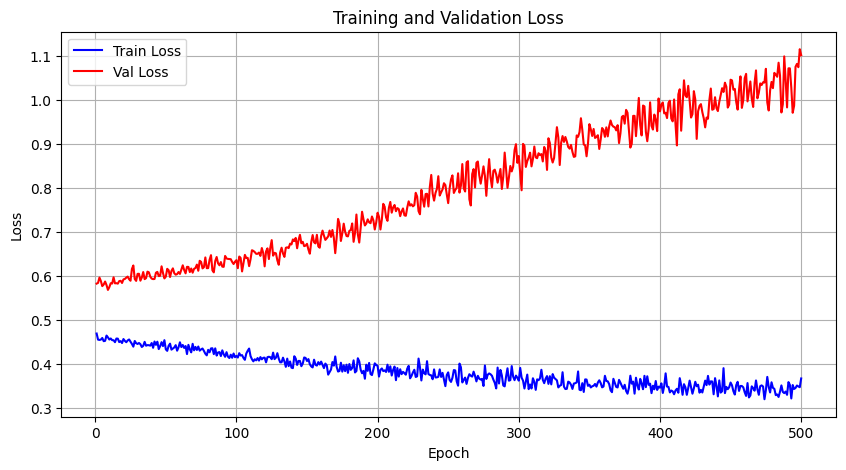

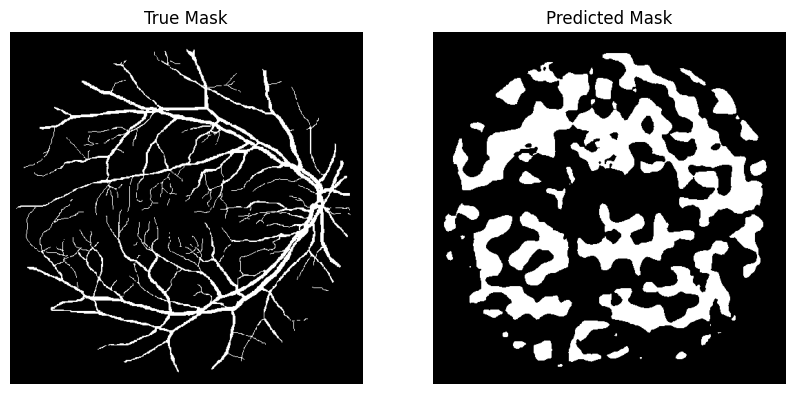

In [23]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(500):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)

pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Epoch 1 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 1: Train Loss=0.3985, Val Loss=0.5839, IoU=0.2587, Dice=0.4111


Epoch 2 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 2: Train Loss=0.3935, Val Loss=0.5765, IoU=0.2562, Dice=0.4079


Epoch 3 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 3: Train Loss=0.4428, Val Loss=0.5493, IoU=0.2489, Dice=0.3986


Epoch 4 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 4: Train Loss=0.4462, Val Loss=0.5190, IoU=0.2395, Dice=0.3864
Best model saved!


Epoch 5 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 5: Train Loss=0.4070, Val Loss=0.4935, IoU=0.2299, Dice=0.3738
Best model saved!


Epoch 6 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 6: Train Loss=0.4229, Val Loss=0.4760, IoU=0.2217, Dice=0.3630
Best model saved!


Epoch 7 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 7: Train Loss=0.4066, Val Loss=0.4658, IoU=0.2171, Dice=0.3568
Best model saved!


Epoch 8 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 8: Train Loss=0.3794, Val Loss=0.4614, IoU=0.2154, Dice=0.3545
Best model saved!


Epoch 9 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 9: Train Loss=0.3982, Val Loss=0.4604, IoU=0.2163, Dice=0.3556
Best model saved!


Epoch 10 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 10: Train Loss=0.4100, Val Loss=0.4620, IoU=0.2192, Dice=0.3596


Epoch 11 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 11: Train Loss=0.3912, Val Loss=0.4658, IoU=0.2233, Dice=0.3651


Epoch 12 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 12: Train Loss=0.4026, Val Loss=0.4715, IoU=0.2282, Dice=0.3716


Epoch 13 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 13: Train Loss=0.3850, Val Loss=0.4798, IoU=0.2332, Dice=0.3782


Epoch 14 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 14: Train Loss=0.3730, Val Loss=0.4895, IoU=0.2375, Dice=0.3839


Epoch 15 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 15: Train Loss=0.3783, Val Loss=0.4992, IoU=0.2405, Dice=0.3878


Epoch 16 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 16: Train Loss=0.3862, Val Loss=0.5068, IoU=0.2414, Dice=0.3889


Epoch 17 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 17: Train Loss=0.4020, Val Loss=0.5103, IoU=0.2400, Dice=0.3870


Epoch 18 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 18: Train Loss=0.3630, Val Loss=0.5113, IoU=0.2376, Dice=0.3840


Epoch 19 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Epoch 19: Train Loss=0.3969, Val Loss=0.5110, IoU=0.2351, Dice=0.3808


Epoch 20 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-25-aa80c18a50b1>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch 20: Train Loss=0.3986, Val Loss=0.5102, IoU=0.2329, Dice=0.3779


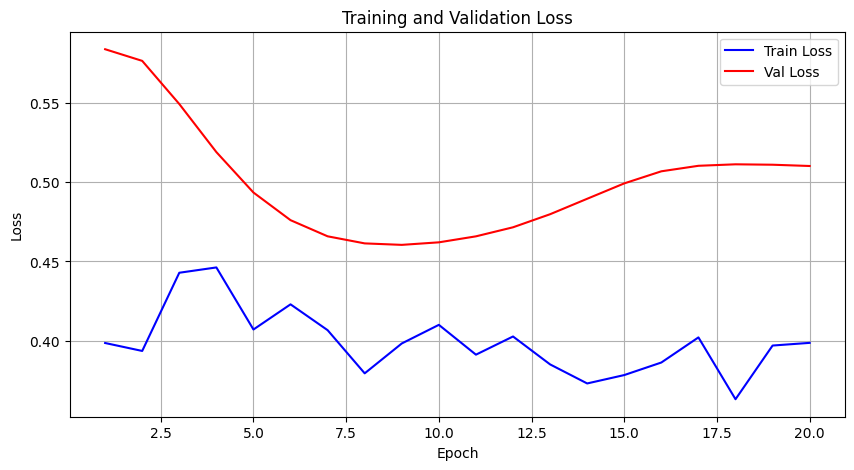

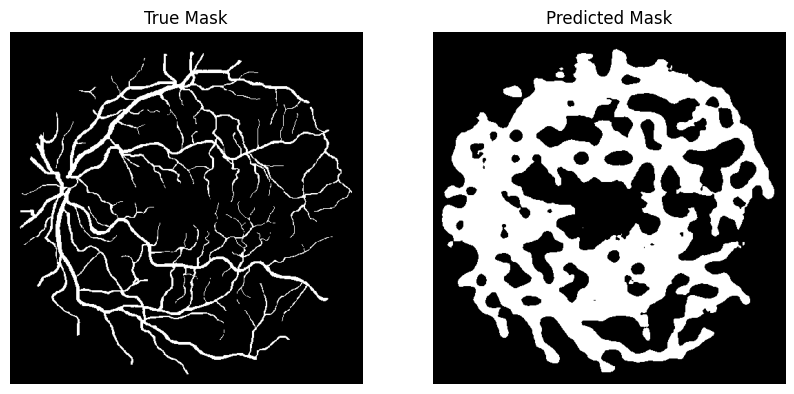

In [25]:
train_losses = []
val_losses = []

for epoch in range(20):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)


pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Epoch 1 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 1: Train Loss=0.3639, Val Loss=0.5090, IoU=0.2308, Dice=0.3751


Epoch 2 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 2: Train Loss=0.3793, Val Loss=0.5081, IoU=0.2294, Dice=0.3732


Epoch 3 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 3: Train Loss=0.3800, Val Loss=0.5085, IoU=0.2293, Dice=0.3730


Epoch 4 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 4: Train Loss=0.3854, Val Loss=0.5107, IoU=0.2303, Dice=0.3744


Epoch 5 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 5: Train Loss=0.3752, Val Loss=0.5131, IoU=0.2319, Dice=0.3765


Epoch 6 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 6: Train Loss=0.3586, Val Loss=0.5150, IoU=0.2343, Dice=0.3796


Epoch 7 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 7: Train Loss=0.3734, Val Loss=0.5178, IoU=0.2366, Dice=0.3827


Epoch 8 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 8: Train Loss=0.3595, Val Loss=0.5195, IoU=0.2389, Dice=0.3857


Epoch 9 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 9: Train Loss=0.3776, Val Loss=0.5213, IoU=0.2410, Dice=0.3884


Epoch 10 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 10: Train Loss=0.3565, Val Loss=0.5212, IoU=0.2430, Dice=0.3909


Epoch 11 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 11 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 11: Train Loss=0.3742, Val Loss=0.5209, IoU=0.2448, Dice=0.3933


Epoch 12 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 12 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 12: Train Loss=0.3786, Val Loss=0.5185, IoU=0.2462, Dice=0.3952


Epoch 13 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 13 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 13: Train Loss=0.3612, Val Loss=0.5166, IoU=0.2468, Dice=0.3959


Epoch 14 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 14 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 14: Train Loss=0.3635, Val Loss=0.5160, IoU=0.2474, Dice=0.3967


Epoch 15 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 15 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 15: Train Loss=0.3557, Val Loss=0.5156, IoU=0.2481, Dice=0.3975


Epoch 16 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 16 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 16: Train Loss=0.3531, Val Loss=0.5160, IoU=0.2484, Dice=0.3979


Epoch 17 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 17 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 17: Train Loss=0.3658, Val Loss=0.5166, IoU=0.2484, Dice=0.3980


Epoch 18 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 18 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 18: Train Loss=0.3595, Val Loss=0.5178, IoU=0.2481, Dice=0.3976


Epoch 19 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 19 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 19: Train Loss=0.3564, Val Loss=0.5190, IoU=0.2482, Dice=0.3976


Epoch 20 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 20 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 20: Train Loss=0.3624, Val Loss=0.5207, IoU=0.2483, Dice=0.3979


Epoch 21 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 21 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 21: Train Loss=0.3722, Val Loss=0.5230, IoU=0.2485, Dice=0.3980


Epoch 22 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 22 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 22: Train Loss=0.3513, Val Loss=0.5234, IoU=0.2483, Dice=0.3978


Epoch 23 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 23 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 23: Train Loss=0.3532, Val Loss=0.5256, IoU=0.2484, Dice=0.3980


Epoch 24 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 24 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 24: Train Loss=0.3731, Val Loss=0.5276, IoU=0.2488, Dice=0.3985


Epoch 25 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch 25: Train Loss=0.3676, Val Loss=0.5287, IoU=0.2487, Dice=0.3983


Epoch 26 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 26 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 26: Train Loss=0.3455, Val Loss=0.5281, IoU=0.2484, Dice=0.3979


Epoch 27 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 27 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 27: Train Loss=0.3700, Val Loss=0.5290, IoU=0.2481, Dice=0.3976


Epoch 28 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 28 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 28: Train Loss=0.3661, Val Loss=0.5286, IoU=0.2476, Dice=0.3969


Epoch 29 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 29 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 29: Train Loss=0.3524, Val Loss=0.5282, IoU=0.2468, Dice=0.3959


Epoch 30 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 30: Train Loss=0.3962, Val Loss=0.5270, IoU=0.2464, Dice=0.3954


Epoch 31 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 31 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 31: Train Loss=0.3823, Val Loss=0.5251, IoU=0.2453, Dice=0.3940


Epoch 32 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 32 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 32: Train Loss=0.3475, Val Loss=0.5232, IoU=0.2443, Dice=0.3926


Epoch 33 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 33 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 33: Train Loss=0.3570, Val Loss=0.5224, IoU=0.2440, Dice=0.3922


Epoch 34 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 34 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 34: Train Loss=0.3575, Val Loss=0.5227, IoU=0.2441, Dice=0.3924


Epoch 35 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 35 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 35: Train Loss=0.3531, Val Loss=0.5250, IoU=0.2442, Dice=0.3925


Epoch 36 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 36: Train Loss=0.3672, Val Loss=0.5278, IoU=0.2445, Dice=0.3930


Epoch 37 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 37 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 37: Train Loss=0.3719, Val Loss=0.5307, IoU=0.2447, Dice=0.3932


Epoch 38 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 38 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 38: Train Loss=0.3681, Val Loss=0.5321, IoU=0.2448, Dice=0.3934


Epoch 39 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 39 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 39: Train Loss=0.3625, Val Loss=0.5320, IoU=0.2449, Dice=0.3935


Epoch 40 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 40 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 40: Train Loss=0.3552, Val Loss=0.5329, IoU=0.2448, Dice=0.3933


Epoch 41 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 41 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch 41: Train Loss=0.3368, Val Loss=0.5335, IoU=0.2449, Dice=0.3935


Epoch 42 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 42 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 42: Train Loss=0.3472, Val Loss=0.5346, IoU=0.2454, Dice=0.3941


Epoch 43 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 43 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 43: Train Loss=0.3623, Val Loss=0.5348, IoU=0.2455, Dice=0.3942


Epoch 44 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 44 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 44: Train Loss=0.3773, Val Loss=0.5330, IoU=0.2450, Dice=0.3936


Epoch 45 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 45 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 45: Train Loss=0.3823, Val Loss=0.5305, IoU=0.2438, Dice=0.3921


Epoch 46 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 46 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 46: Train Loss=0.3620, Val Loss=0.5271, IoU=0.2426, Dice=0.3904


Epoch 47 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 47 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 47: Train Loss=0.3593, Val Loss=0.5248, IoU=0.2418, Dice=0.3895


Epoch 48 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 48 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 48: Train Loss=0.3654, Val Loss=0.5239, IoU=0.2417, Dice=0.3893


Epoch 49 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 49 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 49: Train Loss=0.3578, Val Loss=0.5234, IoU=0.2419, Dice=0.3895


Epoch 50 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 50: Train Loss=0.3623, Val Loss=0.5251, IoU=0.2425, Dice=0.3903


Epoch 51 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 51 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 51: Train Loss=0.3712, Val Loss=0.5277, IoU=0.2430, Dice=0.3910


Epoch 52 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 52 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 52: Train Loss=0.3491, Val Loss=0.5301, IoU=0.2438, Dice=0.3921


Epoch 53 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 53 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch 53: Train Loss=0.3537, Val Loss=0.5336, IoU=0.2450, Dice=0.3935


Epoch 54 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 54 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 54: Train Loss=0.3767, Val Loss=0.5361, IoU=0.2459, Dice=0.3947


Epoch 55 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 55 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 55: Train Loss=0.3583, Val Loss=0.5379, IoU=0.2468, Dice=0.3958


Epoch 56 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 56 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 56: Train Loss=0.3537, Val Loss=0.5377, IoU=0.2469, Dice=0.3961


Epoch 57 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 57 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 57: Train Loss=0.3448, Val Loss=0.5370, IoU=0.2469, Dice=0.3960


Epoch 58 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 58 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 58: Train Loss=0.3676, Val Loss=0.5342, IoU=0.2463, Dice=0.3953


Epoch 59 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 59 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 59: Train Loss=0.3735, Val Loss=0.5309, IoU=0.2450, Dice=0.3936


Epoch 60 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 60 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 60: Train Loss=0.3487, Val Loss=0.5275, IoU=0.2439, Dice=0.3922


Epoch 61 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 61 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 61: Train Loss=0.3753, Val Loss=0.5249, IoU=0.2432, Dice=0.3912


Epoch 62 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 62 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 62: Train Loss=0.3596, Val Loss=0.5241, IoU=0.2422, Dice=0.3900


Epoch 63 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 63 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 63: Train Loss=0.3634, Val Loss=0.5233, IoU=0.2417, Dice=0.3893


Epoch 64 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 64 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 64: Train Loss=0.3551, Val Loss=0.5252, IoU=0.2416, Dice=0.3892


Epoch 65 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 65 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 65: Train Loss=0.3624, Val Loss=0.5284, IoU=0.2423, Dice=0.3901


Epoch 66 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 66 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 66: Train Loss=0.3593, Val Loss=0.5326, IoU=0.2434, Dice=0.3914


Epoch 67 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 67 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 67: Train Loss=0.3681, Val Loss=0.5372, IoU=0.2448, Dice=0.3933


Epoch 68 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 68 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 68: Train Loss=0.3691, Val Loss=0.5422, IoU=0.2467, Dice=0.3958


Epoch 69 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 69 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 69: Train Loss=0.3601, Val Loss=0.5462, IoU=0.2483, Dice=0.3978


Epoch 70 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 70 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 70: Train Loss=0.3474, Val Loss=0.5490, IoU=0.2501, Dice=0.4001


Epoch 71 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 71 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 71: Train Loss=0.3721, Val Loss=0.5519, IoU=0.2512, Dice=0.4015


Epoch 72 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 72 [Val]: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Epoch 72: Train Loss=0.3425, Val Loss=0.5525, IoU=0.2520, Dice=0.4025


Epoch 73 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 73 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 73: Train Loss=0.3512, Val Loss=0.5523, IoU=0.2524, Dice=0.4031


Epoch 74 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 74 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 74: Train Loss=0.3371, Val Loss=0.5505, IoU=0.2525, Dice=0.4033


Epoch 75 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 75 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch 75: Train Loss=0.3623, Val Loss=0.5488, IoU=0.2526, Dice=0.4033


Epoch 76 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 76 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 76: Train Loss=0.3481, Val Loss=0.5460, IoU=0.2521, Dice=0.4027


Epoch 77 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 77 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 77: Train Loss=0.3601, Val Loss=0.5441, IoU=0.2518, Dice=0.4023


Epoch 78 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 78 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 78: Train Loss=0.3508, Val Loss=0.5410, IoU=0.2511, Dice=0.4014


Epoch 79 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 79 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 79: Train Loss=0.3529, Val Loss=0.5384, IoU=0.2504, Dice=0.4006


Epoch 80 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 80 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 80: Train Loss=0.3481, Val Loss=0.5367, IoU=0.2496, Dice=0.3995


Epoch 81 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 81 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch 81: Train Loss=0.3693, Val Loss=0.5354, IoU=0.2485, Dice=0.3980


Epoch 82 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 82 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 82: Train Loss=0.3639, Val Loss=0.5329, IoU=0.2474, Dice=0.3967


Epoch 83 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 83 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 83: Train Loss=0.3777, Val Loss=0.5331, IoU=0.2463, Dice=0.3953


Epoch 84 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 84 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 84: Train Loss=0.3412, Val Loss=0.5336, IoU=0.2454, Dice=0.3941


Epoch 85 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 85 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 85: Train Loss=0.3443, Val Loss=0.5364, IoU=0.2453, Dice=0.3940


Epoch 86 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 86 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 86: Train Loss=0.3636, Val Loss=0.5398, IoU=0.2457, Dice=0.3945


Epoch 87 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 87 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 87: Train Loss=0.3565, Val Loss=0.5438, IoU=0.2462, Dice=0.3952


Epoch 88 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 88 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 88: Train Loss=0.3504, Val Loss=0.5463, IoU=0.2467, Dice=0.3958


Epoch 89 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 89 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch 89: Train Loss=0.3647, Val Loss=0.5490, IoU=0.2468, Dice=0.3960


Epoch 90 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 90 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch 90: Train Loss=0.3732, Val Loss=0.5503, IoU=0.2471, Dice=0.3963


Epoch 91 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 91 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 91: Train Loss=0.3685, Val Loss=0.5495, IoU=0.2468, Dice=0.3959


Epoch 92 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 92 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 92: Train Loss=0.3632, Val Loss=0.5474, IoU=0.2463, Dice=0.3953


Epoch 93 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 93 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 93: Train Loss=0.3679, Val Loss=0.5453, IoU=0.2456, Dice=0.3944


Epoch 94 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 94 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch 94: Train Loss=0.3572, Val Loss=0.5429, IoU=0.2452, Dice=0.3939


Epoch 95 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 95 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 95: Train Loss=0.3771, Val Loss=0.5398, IoU=0.2448, Dice=0.3934


Epoch 96 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 96 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 96: Train Loss=0.3446, Val Loss=0.5374, IoU=0.2444, Dice=0.3928


Epoch 97 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 97 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 97: Train Loss=0.3604, Val Loss=0.5376, IoU=0.2448, Dice=0.3933


Epoch 98 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 98 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 98: Train Loss=0.3778, Val Loss=0.5386, IoU=0.2460, Dice=0.3949


Epoch 99 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 99 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch 99: Train Loss=0.3628, Val Loss=0.5409, IoU=0.2464, Dice=0.3954


Epoch 100 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-29-edbbe1672a95>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 100: Train Loss=0.3327, Val Loss=0.5436, IoU=0.2473, Dice=0.3966


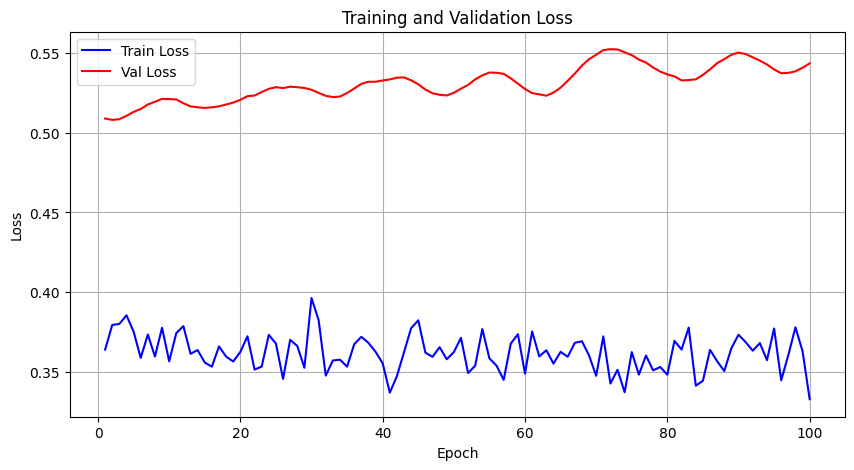

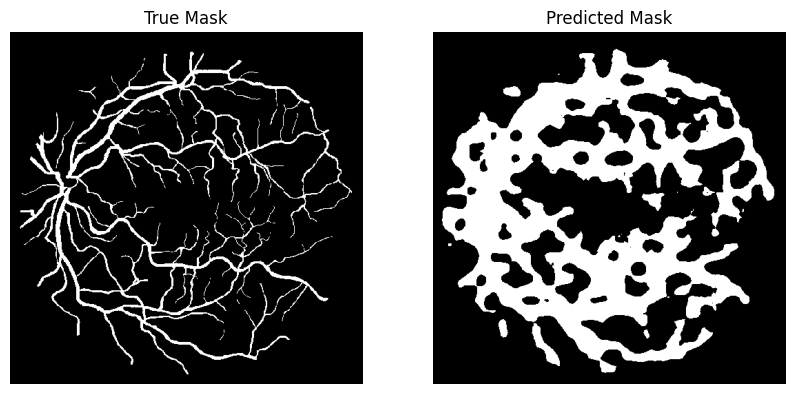

In [29]:
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    total_train_loss = 0

    for pixel_values, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pixel_values = pixel_values.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for pixel_values, masks, fovs in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = pixel_values.to(device)
            masks = masks.to(device)
            fovs = fovs.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = loss_fn(logits, masks)
                preds = torch.argmax(logits, dim=1)

            total_val_loss += loss.item()

            for pred, target, fov in zip(preds, masks, fovs):
                fov = fov.squeeze()
                pred = pred[fov == 1].cpu().numpy()
                target = target[fov == 1].cpu().numpy()
                all_preds.extend(pred.flatten())
                all_targets.extend(target.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    iou = jaccard_score(all_targets, all_preds, average='binary')
    dice = f1_score(all_targets, all_preds, average='binary')

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_drive.pth")
        print("Best model saved!")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


sample_idx = 0
pixel_values, masks, _ = val_loader.dataset[sample_idx]
pixel_values = pixel_values.unsqueeze(0).to(device)
masks = masks.unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits
    logits = nn.functional.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.argmax(logits, dim=1)


pred_mask = preds.squeeze().cpu().numpy()
true_mask = masks.squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_mask, cmap='gray')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [13]:
print(torch.unique(masks))

tensor([0, 1], device='cuda:0')


In [14]:
print(logits.shape, masks.shape)

torch.Size([4, 2, 512, 512]) torch.Size([4, 512, 512])


In [15]:
print(torch.unique(preds))
print(torch.unique(masks))

tensor([0], device='cuda:0')
tensor([0, 1], device='cuda:0')


In [16]:
background_count = torch.sum(masks == 0).item()
vessel_count = torch.sum(masks == 1).item()
print(f"Background pixels: {background_count}, Vessel pixels: {vessel_count}")


Background pixels: 956208, Vessel pixels: 92368
